In [1]:
import domain_adapt_run.domain_adapt_run.constants as constants
cache_folder_name = 'KMM_weighted_kernel_sufficient_dimension_reduction_cleaned_more'
seed = 44

In [2]:
import autograd.numpy as np
np.random.seed(seed)
import python_utils.python_utils.basic as basic
import python_utils.python_utils.caching as caching
log_folder = '%s/%s' % (constants.cache_folder, cache_folder_name)
caching.init(constants.cache_folder, constants.which_hash, basic.archiver(log_folder))
%load_ext autoreload
%autoreload 2

[Errno 17] File exists: '/Users/fultonw/Documents/projects/runs/domain_adapt_run/cache/KMM_weighted_kernel_sufficient_dimension_reduction_cleaned_more'


In [3]:
import matplotlib.pyplot as plt
import matplotlib
from mpl_toolkits.mplot3d import Axes3D
from IPython.display import display_pretty, display_html
import python_utils.python_utils.basic as basic
import pandas as pd
import pdb
import itertools
import functools
import scipy.stats, scipy
import cvxopt
import domain_adapt.domain_adapt.kernels as kernels
import pymanopt
import pprint, autograd
import scipy.optimize

Couldn't import dot_parser, loading of dot files will not be possible.


## define data

In [4]:
# x is generated based on u coordinates.  v basis coordinates determines y 
x_dim = 2
u_dim = 1
v_dim = 1
y_dim = 1
u_perp_dim = x_dim - u_dim
#u_perp_dim = 0
#u_bases = kernels.ortho(np.array([[1.,0.],[0.,1.]]).T)
u_bases = np.eye(x_dim)[:,u_dim:]
#u_bases = kernels.ortho(np.array([[1.,0.]]).T)
if u_perp_dim > 0:
    #u_perp_bases = kernels.ortho(np.array([[0.,1.]]).T)
    u_perp_bases = np.eye(x_dim)[:,0:u_dim]
v_perp_dim = x_dim - v_dim
v_start_dim = 1
v_bases = np.eye(x_dim)[:,v_start_dim:v_start_dim+v_dim]
#v_bases = kernels.ortho(np.array([[1.,0.]]).T)

In [5]:
u_perp_bases

array([[ 1.],
       [ 0.]])

In [6]:
#
desired_dim = 1

In [7]:
# define train u distribution
p_u_train_dist = scipy.stats.multivariate_normal(mean=0.*np.ones(shape=u_dim), cov=np.eye(u_dim)*1.)
#p_u_train_dist = scipy.stats.uniform(loc=(0.5**2+0.5**2)**.5, scale=8.**.5 - ((0.5**2+0.5**2)**.5))
p_u_train_pdf = p_u_train_dist.pdf
p_u_train_sample = p_u_train_dist.rvs

In [8]:
# define test u distribution
p_u_test_dist = scipy.stats.multivariate_normal(mean=-0.*np.ones(shape=u_dim), cov=np.eye(u_dim)*1.)
#p_u_test_dist = scipy.stats.uniform(loc=0., scale=2.**.5)
p_u_test_pdf = p_u_test_dist.pdf
p_u_test_sample = p_u_test_dist.rvs

In [9]:
# define shared u_perp distribution
if u_perp_dim > 0:
#    p_u_perp_dist = scipy.stats.multivariate_normal(mean=np.zeros(shape=u_perp_dim), cov=np.eye(u_perp_dim)*0.029)
#    p_u_perp_dist = scipy.stats.multivariate_normal(mean=np.zeros(shape=u_perp_dim), cov=np.eye(u_perp_dim)*0.049)
    p_u_perp_dist = scipy.stats.multivariate_normal(mean=np.zeros(shape=u_perp_dim))
    p_u_perp_pdf = p_u_perp_dist.pdf
    p_u_perp_sample = p_u_perp_dist.rvs

In [10]:
def f_v(v): 
    print v
    if 1*np.ones(v_dim).dot(v) > 0:
    #if v > 0:
        return 500
    else:
        return -500
y_var = 0.002
#p_y_noise_sample = scipy.stats.multivariate_normal(mean=np.zeros(shape=y_dim),cov=np.eye(y_dim)*y_var).rvs
logistic = lambda x: 1. / (1. + np.exp(-x))
p_y_given_v_sample = lambda v: int(np.random.random() < logistic(f_v(v)))

In [12]:
# specify number of data to generate
num_train = 200
num_test = 200

In [13]:
# generate data
expand = lambda s: s.reshape(len(s),1) if len(s.shape) == 1 else s
us_train = expand(np.array([p_u_train_sample() for i in xrange(num_train)]))
us_test = expand(np.array([p_u_test_sample() for i in xrange(num_test)]))
if u_perp_dim > 0:
    us_perp_train = expand(np.array([p_u_perp_sample() for i in xrange(num_train)]))
    us_perp_test = expand(np.array([p_u_perp_sample() for i in xrange(num_test)]))
xs_train = np.dot(us_train, u_bases.T)
xs_test = np.dot(us_test, u_bases.T)
if u_perp_dim > 0:
    xs_train += np.dot(us_perp_train, u_perp_bases.T)
    xs_test += np.dot(us_perp_test, u_perp_bases.T)
vs_train = np.dot(xs_train, v_bases)
vs_test = np.dot(xs_test, v_bases)
ys_train = np.array([p_y_given_v_sample(v) for v in vs_train])
ys_test = np.array([p_y_given_v_sample(v) for v in vs_test])

[-0.75061472]
[ 1.31635732]
[ 1.24614003]
[-1.60491574]
[-1.46814368]
[-1.71507046]
[ 1.85878369]
[ 0.08758798]
[-0.0523222]
[ 0.55547164]
[-0.96340369]
[-0.18032147]
[-1.18340916]
[ 0.60544592]
[-0.95165055]
[ 0.36085606]
[ 1.06061026]
[-0.11715218]
[ 0.82566485]
[-1.20981355]
[-1.19050362]
[ 0.21987182]
[-0.21291913]
[-1.41149914]
[-0.48298102]
[ 1.20176208]
[-0.70580303]
[ 0.02518135]
[-0.39112815]
[ 0.19313912]
[ 0.34929093]
[ 0.59118838]
[ 0.52040987]
[ 0.82522239]
[ 0.42620351]
[ 0.19564003]
[-0.51411218]
[-3.07368882]
[-0.39515907]
[-0.79539918]
[-0.70320151]
[-1.73739268]
[ 0.75080826]
[-1.86395314]
[ 0.41851098]
[-0.23533384]
[ 0.43210717]
[ 0.87029193]
[ 2.00862219]
[ 1.37177091]
[ 1.05859789]
[ 1.44533756]
[ 0.04882329]
[ 0.09032952]
[-0.48025681]
[ 0.30066274]
[ 1.11297983]
[-0.01931505]
[-0.0008076]
[-0.63853023]
[ 1.59468337]
[ 0.01861299]
[ 0.56140867]
[-0.19847682]
[ 0.46320755]
[-1.81909398]
[ 0.13292482]
[-0.61707964]
[ 1.3081795]
[ 0.77583771]
[-0.2801704]
[-0.723937

## plot raw data

In [14]:
# define some constants for plotting
xs_plot_dim_1 = 0
xs_plot_dim_2 = 1
x_low, x_high = -2, 4
y_low, y_high = -2, 4
color_wheel = itertools.cycle(['c','b','k','g'])

/Users/fultonw/Library/Enthought/Canopy_64bit/User/lib/python2.7/site-packages/matplotlib/collections.py:548: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == 'face':


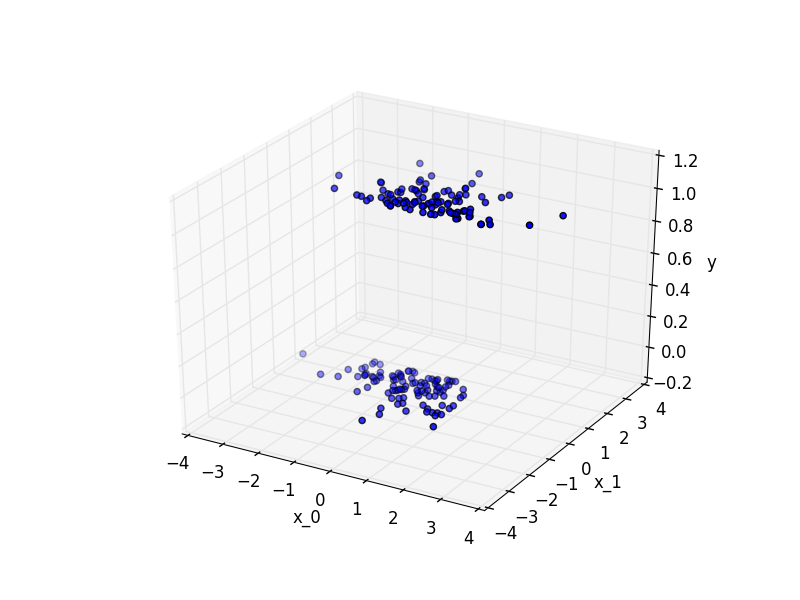

In [15]:
# plot train data, 3d
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(xs_train[:,xs_plot_dim_1],xs_train[:,xs_plot_dim_2],ys_train)
ax.set_xlabel('x_%d' % xs_plot_dim_1)
ax.set_ylabel('x_%d' % xs_plot_dim_2)
ax.set_zlabel('y')
basic.display_fig_inline(fig)

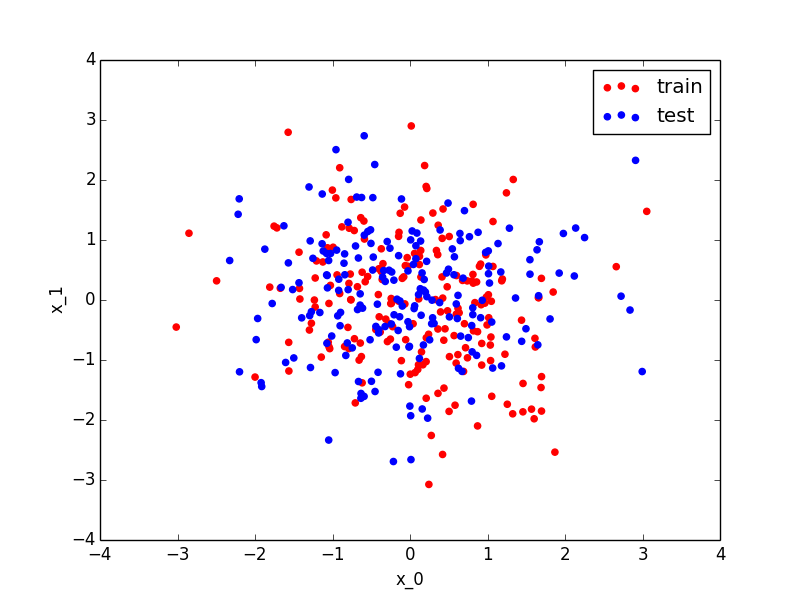

In [16]:
# plot train xs, test xs, 2d
fig, ax = plt.subplots()
ax.scatter(xs_train[:,xs_plot_dim_1],xs_train[:,xs_plot_dim_2], color='r', label='train')
ax.scatter(xs_test[:,xs_plot_dim_1],xs_test[:,xs_plot_dim_2], color='b', label='test')
ax.set_xlabel('x_%d' % xs_plot_dim_1)
ax.set_ylabel('x_%d' % xs_plot_dim_2)
ax.legend()
basic.display_fig_inline(fig)

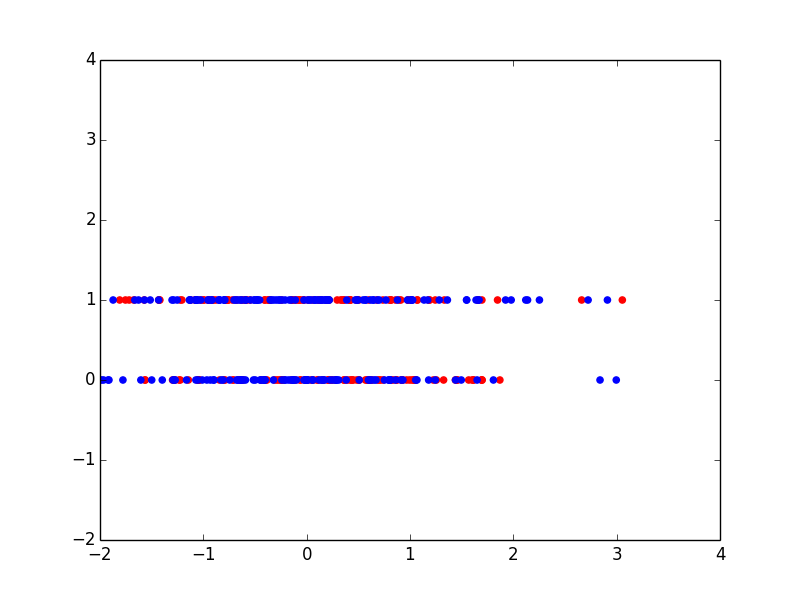

In [17]:
# plot ys1 vs vs1
fig, ax = plt.subplots()
ax.scatter(xs_train[:,0], ys_train, color='r')
ax.scatter(xs_test[:,0], ys_test, color='b')
ax.set_xlim((x_low,x_high))
ax.set_ylim((y_low,y_high))
basic.display_fig_inline(fig)

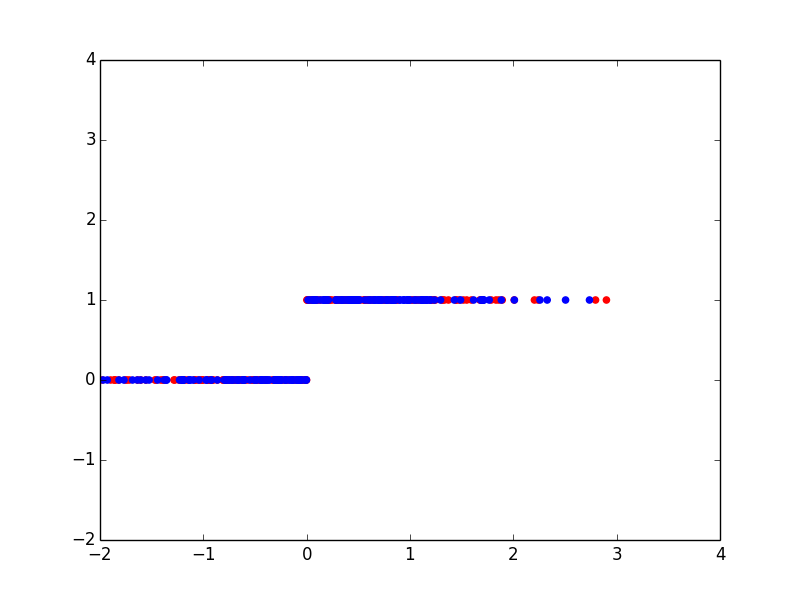

In [18]:
# plot ys2 vs vs2
fig, ax = plt.subplots()
ax.scatter(xs_train[:,1], ys_train, color='r')
ax.scatter(xs_test[:,1], ys_test, color='b')
ax.set_xlim((x_low,x_high))
ax.set_ylim((y_low,y_high))
basic.display_fig_inline(fig)

## define and check supervised term in objective function

## define hyperparameters

In [19]:
#
def mat_median(m):
    l = len(m)
    v = np.arange(l).reshape((l,1))
    return np.median(m[v != v.T])

def median_distance(xs1, xs2):
    if len(xs1.shape) == 1:
        diff = xs1[:,np.newaxis] - xs2[np.newaxis,:]
        norms = np.sum(diff * diff, axis=1) ** 0.5
    elif len(xs1.shape) == 2:
        diff = xs1[:,np.newaxis,:] - xs2[np.newaxis,:,:]
        norms = np.sum(diff * diff, axis=2) ** 0.5
    return mat_median(norms)

In [20]:
# define stuff for SDR
#sigma = 0.1
#sigma = 0.5
#sigma = 0.5
#SDR_get_K = functools.partial(kernels.get_gaussian_K, sigma)
#get_SDR_get_K = lambda P,step: SDR_get_K
get_SDR_get_K = lambda P,step: lambda xs1, xs2: xs1
#get_SDR_get_K = lambda P,step: functools.partial(kernels.get_gaussian_K, (0.5**step) * median_distance(np.dot(xs_train,P),np.dot(xs_train,P)))
#get_SDR_get_K = lambda P,step: functools.partial(kernels.get_gaussian_K, (0.5**step) * median_distance(np.dot(xs_train,P),np.dot(xs_test,P)))

#SDR_get_Ky = lambda P,step: functools.partial(kernels.get_gaussian_K, median_distance(ys_train, ys_train))
#get_SDR_get_Ky = lambda P,step: SDR_get_Ky
get_SDR_get_Ky = lambda P,step: lambda ys1, ys2: ys1
#get_SDR_get_Ky = get_SDR_get_K
SDR_eps = 0.01

In [21]:
# define stuff for KMM
#B_max = 100
#B_max = 100
B_max = 10.
KMM_eps = 0.01
#get_KMM_get_K = lambda P,step: KMM_get_K
#get_KMM_get_K = get_SDR_get_K
sigma = 0.5
KMM_get_K = functools.partial(kernels.get_gaussian_K, sigma)
#get_KMM_get_K = lambda P,step: KMM_get_K
#get_KMM_get_K = lambda P,step: functools.partial(kernels.get_gaussian_K, 1.)
#get_KMM_get_K = lambda P,step: functools.partial(kernels.get_gaussian_K, (0.5**step) * median_distance(np.dot(xs_train,P),np.dot(xs_train,P)))
#get_KMM_get_K = lambda P,step: functools.partial(kernels.get_gaussian_K, (0.5**step) * median_distance(np.dot(xs_train,P),np.dot(xs_test,P)))


In [22]:
# see what bandwidth is like for some random projections
[get_KMM_get_K(kernels.ortho(np.random.uniform(size=(x_dim,v_dim))),0).args[0] for i in xrange(10)]

[0.94083333031491911,
 0.89769302946699714,
 0.92230979871886309,
 0.94508473576627927,
 0.91109440649982498,
 0.92580310929940901,
 0.91791938662096118,
 0.89958491002444785,
 0.89801585479061796,
 0.9332693561507589]

In [23]:
# define linear system solvers
reg_lstsq_solver = lambda A,b: scipy.sparse.linalg.lsmr(A,b)[0]
lstsq_solver = lambda A,b: np.linalg.lstsq(A, b)[0]
cg_solver = lambda A,b: scipy.sparse.linalg.cg(A, b)[0]
#lin_solver = lstsq_solver
#lin_solver = cg_solver
lin_solver = reg_lstsq_solver

In [24]:
# define qp solver
cvxopt_solver = kernels.cvxopt_solver

In [25]:
# define objective fxn, which is the objective Bopt optimizes (Bobj) + tradeoff * ws_distance

#reg = .000001
reg =  .1
#def _Bobj_from_Ks_and_wsopt_and_Bopt(reg, (Ky, SDR_Ku), wsopt, B):
#    # for optimizing to get Bopt
#    return np.sum(wsopt * np.log(1 + np.exp(-Ky * np.dot(SDR_Ku, B)))) + (reg * np.dot(B, B))
Bobj_from_Ks_and_wsopt_and_Bopt = functools.partial(kernels.weighted_logreg_loss, reg)

tradeoff = 1.
#obj_from_Ks_and_wsopt_and_Bopt = lambda (Ky, SDR_Ku), wsopt, Bopt: tradeoff * Bobj_from_Ks_and_wsopt_and_Bopt(wsopt, (Ky, SDR_Ku), Bopt) + kernels.ws_distance(wsopt)
obj_from_Ks_and_wsopt_and_Bopt = lambda (Ky, SDR_Ku), wsopt, Bopt: 1. * Bobj_from_Ks_and_wsopt_and_Bopt(wsopt, (Ky, SDR_Ku), Bopt) #+ tradeoff * kernels.ws_distance(wsopt)
#obj_from_Ks_and_wsopt_and_Bopt = lambda (Ky, SDR_Ku), wsopt, Bopt: kernels.ws_distance(wsopt)

get_Bopt_alternate = functools.partial(kernels.weighted_logreg_get_Bopt, reg)
def get_Bopt(ws, (ys, xs)):
    loss = lambda B: Bobj_from_Ks_and_wsopt_and_Bopt(ws, (ys, xs), B)
    grad = autograd.grad(loss)
    ans = scipy.optimize.minimize(loss, np.random.normal(size=xs.shape[1]),jac=grad)
    #print ans
    return ans['x']
obj_from_wsopt_and_Ks = lambda (Ky, SDR_Ku), wsopt: obj_from_Ks_and_wsopt_and_Bopt((Ky, SDR_Ku), wsopt, get_Bopt(wsopt, (Ky, SDR_Ku)))

In [26]:
# define dobj_dwsopt


# below terms depend on Bobj
the_g = lambda B, wsopt, (Ky, SDR_Ku): Bobj_from_Ks_and_wsopt_and_Bopt(wsopt, (Ky, SDR_Ku), B)
dg_dB = autograd.jacobian(the_g) # ans dim: |x|
d_dwsopt_dg_dB = autograd.jacobian(lambda wsopt,B,(Ky, SDR_Ku): dg_dB(B,wsopt,(Ky, SDR_Ku))) # ans dim: |x| x |p|.  DIFF below
d_dB_dg_dB = autograd.jacobian(autograd.jacobian(the_g))

dobj_dBopt = autograd.jacobian(lambda Bopt, (wsopt, (Ky, SDR_Ku)): obj_from_Ks_and_wsopt_and_Bopt((Ky, SDR_Ku), wsopt, Bopt))

def obj_from_wsopt_and_Bopt_and_Ks(wsopt, Bopt, (Ky, SDR_Ku)):
    return obj_from_Ks_and_wsopt_and_Bopt((Ky, SDR_Ku), wsopt, Bopt)

dobj_dwsopt_thru_wsopt = autograd.jacobian(obj_from_wsopt_and_Bopt_and_Ks)

dobj_dwsopt = functools.partial(kernels.Bopt_get_dobj_dwsopt, get_Bopt, dobj_dwsopt_thru_wsopt, lin_solver, cvxopt_solver, dg_dB, d_dwsopt_dg_dB, d_dB_dg_dB, dobj_dBopt)#, wsopt, (Ky, SDR_Ku))

In [27]:
# define constructor for dobj_dP_thru_Ku

def get_dobj_dP_thru_Ku_stuff(xs_train, SDR_get_K, Ky):

    def the_g2(B, P, (wsopt,Ky)):
        us_train = np.dot(xs_train, P)
        return Bobj_from_Ks_and_wsopt_and_Bopt(wsopt, (Ky, SDR_get_K(us_train,us_train)), B)
    
    dg_dB = autograd.jacobian(the_g2)
    d_dP_dg_dB = autograd.jacobian(lambda P, B, (wsopt,Ky): dg_dB(B, P, (wsopt,Ky)))
    
    #d_dP_dg_dB = autograd.jacobian(lambda P, B, (wsopt,Ky): dg_dB(B, wsopt, (Ky, SDR_get_K(np.dot(xs_train,P),np.dot(xs_train,P)))))
    #d_dP_dg_dB = autograd.jacobian(lambda P,B,(wsopt,(Ky,SDR_Ku)): Bobj_from_Ks_and_wsopt_and_Bopt((Ky, SDR_get_K(np.dot(xs_train,P),np.dot(xs_train,P))), wsopt, B))
    
    d_dB_dg_dB = autograd.jacobian(autograd.jacobian(the_g2))
    
    #dobj_dBopt_check = dobj_dBopt
    
    dobj_dP_thru_Ku = autograd.jacobian(lambda P, wsopt, Bopt: obj_from_Ks_and_wsopt_and_Bopt((Ky, SDR_get_K(np.dot(xs_train,P),np.dot(xs_train,P))), wsopt, Bopt))
    
    return dg_dB, d_dP_dg_dB, d_dB_dg_dB, dobj_dBopt, dobj_dP_thru_Ku

def get_dobj_dP_thru_Ku(xs_train, SDR_get_K, Ky):
    
    dg_dB, d_dP_dg_dB, d_dB_dg_dB, dobj_dBopt, dobj_dP_thru_Ku = get_dobj_dP_thru_Ku_stuff(xs_train, SDR_get_K, Ky)
    
    return functools.partial(kernels.Bopt_get_dobj_dP, xs_train, Ky, SDR_get_K, get_Bopt, dobj_dP_thru_Ku, lin_solver, cvxopt_solver, dg_dB, d_dP_dg_dB, d_dB_dg_dB, dobj_dBopt)#, P, wsopt)

In [28]:
# do gradient checks.  first compute intermediate quantities
P_check = kernels.ortho(np.random.normal(size=(x_dim,desired_dim)))
KMM_get_K_check = get_KMM_get_K(P_check,0)
SDR_get_K_check = get_SDR_get_K(P_check,0)
SDR_get_Ky_check = get_SDR_get_Ky(P_check,0)
us_train_check = np.dot(xs_train, P_check)
us_test_check = np.dot(xs_test, P_check)
KMM_Ku_check, kappau_check = kernels.get_KMM_params(us_train_check, us_test_check, KMM_get_K_check)
A_check, b_check = kernels.get_KMM_ineq_constraints(len(xs_train), B_max, KMM_eps)
wsopt_check = cvxopt_solver(KMM_Ku_check, kappau_check, A_check, b_check)
SDR_Ku_check = SDR_get_K_check(us_train_check, us_train_check)
SDR_Ky_check = SDR_get_Ky_check(ys_train, ys_train)
Bopt_check = get_Bopt(wsopt_check, (SDR_Ky_check, SDR_Ku_check))
Bopt_check_alternate = get_Bopt_alternate(wsopt_check, (SDR_Ky_check, SDR_Ku_check))
print 'sklearn', Bopt_check, Bobj_from_Ks_and_wsopt_and_Bopt(wsopt_check, (SDR_Ky_check, SDR_Ku_check), Bopt_check)
print 'manual', Bopt_check_alternate, Bobj_from_Ks_and_wsopt_and_Bopt(wsopt_check, (SDR_Ky_check, SDR_Ku_check), Bopt_check_alternate)
obj_check = obj_from_Ks_and_wsopt_and_Bopt((SDR_Ky_check, SDR_Ku_check), wsopt_check, Bopt_check)

sklearn [-1.33956013] 121.541912032
manual [-1.18831342] 121.696359466


In [29]:
# gradient check for Bopt_get_dobj_dwsopt_thru_Bopt
# need to define gradient calculator first
dobj_dwsopt_thru_Bopt = functools.partial(kernels.Bopt_get_dobj_dwsopt_thru_Bopt, get_Bopt, dobj_dwsopt_thru_wsopt, lin_solver, cvxopt_solver, dg_dB, d_dwsopt_dg_dB, d_dB_dg_dB, dobj_dBopt)#, wsopt, (Ky, SDR_Ku))
delta = 0.0001
dobj_dwsopt_thru_Bopt_check_val = np.zeros(num_train)
for i in xrange(num_train):
    delta_wsopt_direction = np.zeros(num_train, dtype=float)
    delta_wsopt_direction[i] = 1.
    wsopt_check2 = wsopt_check + (delta * delta_wsopt_direction)
    Bopt_check2 = get_Bopt(wsopt_check2, (SDR_Ky_check, SDR_Ku_check))
    obj_check2 = obj_from_Ks_and_wsopt_and_Bopt((SDR_Ky_check, SDR_Ku_check), wsopt_check, Bopt_check2)
    dobj_dwsopt_thru_Bopt_check_val[i] = (obj_check2 - obj_check) / delta
zip(dobj_dwsopt_thru_Bopt_check_val, dobj_dwsopt_thru_Bopt(wsopt_check, (SDR_Ky_check, SDR_Ku_check)))

L_args len: 2
num_tight: 0
solver error: 1.65436122511e-24


[(-2.6574298317427747e-08, 0.0),
 (1.2590817277668975e-07, -1.2508786121910353e-10),
 (5.6559201766503975e-08, -9.1877717170635952e-11),
 (-2.6716406864579767e-08, 0.0),
 (-2.0747847884194925e-08, 0.0),
 (-1.6200374375330284e-08, 0.0),
 (1.3713474800169934e-07, -1.2994595861566082e-10),
 (1.3098144791001687e-06, 3.6975056701087609e-10),
 (-2.6574298317427747e-08, 0.0),
 (1.2005614280496957e-05, 1.1087637844393306e-09),
 (-2.6574298317427747e-08, 0.0),
 (-2.6574298317427747e-08, 0.0),
 (-2.6574298317427747e-08, 0.0),
 (1.1183942660863977e-07, -1.1906548565664925e-10),
 (-2.6432189770275727e-08, 0.0),
 (4.1529801819706336e-06, 6.3359445372610254e-10),
 (1.6996182239381596e-07, -1.2476231516459487e-10),
 (-2.6432189770275727e-08, 0.0),
 (5.7269744502264075e-08, -8.4016028124867003e-11),
 (-2.6574298317427747e-08, 0.0),
 (1.7053025658242404e-09, 0.0),
 (7.631228982063476e-08, 1.0258943627745949e-10),
 (-2.6574298317427747e-08, 0.0),
 (-2.6574298317427747e-08, 0.0),
 (-4.2632564145606011e-1

In [30]:
# gradient check for Bopt_get_dobj_dwsopt
delta = 0.0000001
dobj_dwsopt_check = np.zeros(num_train)
for i in xrange(num_train):
    delta_wsopt_direction = np.zeros(num_train, dtype=float)
    delta_wsopt_direction[i] = 1.
    wsopt_check2 = wsopt_check + (delta * delta_wsopt_direction)
    obj_check2 = obj_from_wsopt_and_Ks((SDR_Ky_check, SDR_Ku_check), wsopt_check2)
    dobj_dwsopt_check[i] = (obj_check2 - obj_check) / delta
zip(dobj_dwsopt_check,dobj_dwsopt(wsopt_check, (SDR_Ky_check, SDR_Ku_check)))

L_args len: 2
num_tight: 0
solver error: 2.06795153138e-25


[(0.69312065420490399, 0.69314718055994529),
 (0.17646755168243544, 0.17649401242703233),
 (0.464190605953263, 0.46419047178777673),
 (0.69312065420490399, 0.69314718055994529),
 (0.69312108053054544, 0.69314718055994529),
 (0.69312093842199829, 0.69314718055994529),
 (0.27573733518693189, 0.27573534431654534),
 (1.3570375756444264, 1.3570401580087048),
 (0.69312065420490399, 0.69314718055994529),
 (2.6198840430424752, 2.6199020231504262),
 (0.69312051209635683, 0.69314718055994529),
 (0.69312065420490399, 0.69314718055994529),
 (0.69312164896473405, 0.69314718055994529),
 (0.3587473429433885, 0.35877374922604355),
 (0.69312221739892266, 0.69314718055994529),
 (1.7971470356314967, 1.7971733196560364),
 (0.32530110161133052, 0.32532580224661406),
 (0.69312065420490399, 0.69314718055994529),
 (0.48831779508873296, 0.48833143608270241),
 (0.69312079631345114, 0.69314718055994529),
 (0.69312065420490399, 0.69314718055994529),
 (0.89464521124682506, 0.89467117754304659),
 (0.693120512096356

In [31]:
# gradient check for Bopt_get_dobj_dP_thru_Bopt

dg_dB_check, d_dP_dg_dB_check, d_dB_dg_dB_check, dobj_dBopt_check, dobj_dP_thru_Ku_check = get_dobj_dP_thru_Ku_stuff(xs_train, SDR_get_K_check, SDR_Ky_check)

dobj_dP_thru_Bopt_check = functools.partial(kernels.Bopt_get_dobj_dP_thru_Bopt, SDR_Ky_check, SDR_get_K_check, get_Bopt, dobj_dP_thru_Ku_check, lin_solver, cvxopt_solver, dg_dB_check, d_dP_dg_dB_check, d_dB_dg_dB_check, dobj_dBopt_check)#, P, wsopt)
delta = .000001
dobj_dP_thru_Bopt_check_val = np.zeros((x_dim,desired_dim))
for i in xrange(x_dim):
    for j in xrange(desired_dim):
        delta_P_direction = np.zeros((x_dim,desired_dim), dtype=float)
        delta_P_direction[i,j] = 1.
        P_check2 = P_check + (delta * delta_P_direction)
        us_train_check2 = np.dot(xs_train, P_check2)
        SDR_Ku_check2 = SDR_get_K_check(us_train_check2, us_train_check2)
        Bopt_check2 = get_Bopt(wsopt_check, (SDR_Ky_check, SDR_Ku_check2))
        obj_check2 = obj_from_Ks_and_wsopt_and_Bopt((SDR_Ky_check, SDR_Ku_check), wsopt_check, Bopt_check2)
        dobj_dP_thru_Bopt_check_val[i,j] = (obj_check2 - obj_check) / delta
print dobj_dP_thru_Bopt_check_val
print dobj_dP_thru_Bopt_check(P_check, wsopt_check, (SDR_Ky_check, SDR_Ku_check))

[[  3.14628323e-05]
 [  5.59907676e-06]]
L_args len: 2
num_tight: 0
solver error: 4.23516473627e-22
[[ -7.30441049e-06]
 [ -3.36032037e-06]]


In [32]:
# gradient check for Bopt_get_dobj_dP
dobj_dP_check = get_dobj_dP_thru_Ku(xs_train, SDR_get_K_check, SDR_Ky_check)
delta = .0000001
dobj_dP_check_val = np.zeros((x_dim,desired_dim))
for i in xrange(x_dim):
    for j in xrange(desired_dim):
        delta_P_direction = np.zeros((x_dim,desired_dim), dtype=float)
        delta_P_direction[i,j] = 1.
        P_check2 = P_check + (delta * delta_P_direction)
        us_train_check2 = np.dot(xs_train, P_check2)
        SDR_Ku_check2 = SDR_get_K_check(us_train_check2, us_train_check2)
        #Bopt_check2 = get_Bopt(wsopt_check, (SDR_Ky_check, SDR_Ku_check2))
        #obj_check2 = obj_from_Ks_and_wsopt_and_Bopt((SDR_Ky_check, SDR_Ku_check), wsopt_check, Bopt_check2)
        obj_check2 = obj_from_wsopt_and_Ks((SDR_Ky_check, SDR_Ku_check2), wsopt_check)
        dobj_dP_check_val[i,j] = (obj_check2 - obj_check) / delta
print dobj_dP_check_val
print dobj_dP_check(P_check, wsopt_check)#, (SDR_Ky_check, SDR_Ku_check)

[[ 21.52490993]
 [ 32.36128748]]
L_args len: 2
num_tight: 0
solver error: 4.13590306277e-25
[[ 21.52491596]
 [ 32.36131324]]


In [33]:
#assert False

In [34]:
#assert False

In [35]:
# define fxn that takes in stuff that changes over iterations
get_obj_and_dobj_dP = lambda KMM_get_K, SDR_get_K, SDR_get_Ky: kernels.get_obj_and_obj_gradient(KMM_get_K, B_max, KMM_eps, SDR_get_K, SDR_get_Ky, obj_from_wsopt_and_Ks, dobj_dwsopt, get_dobj_dP_thru_Ku, lin_solver, cvxopt_solver, xs_train, xs_test, ys_train)

## before optimizing, get a sense of what answer should be

test KMM sigma: 0.898554649068
test_P: [[ 0.]
 [ 1.]] obj_val: 74.9279894001


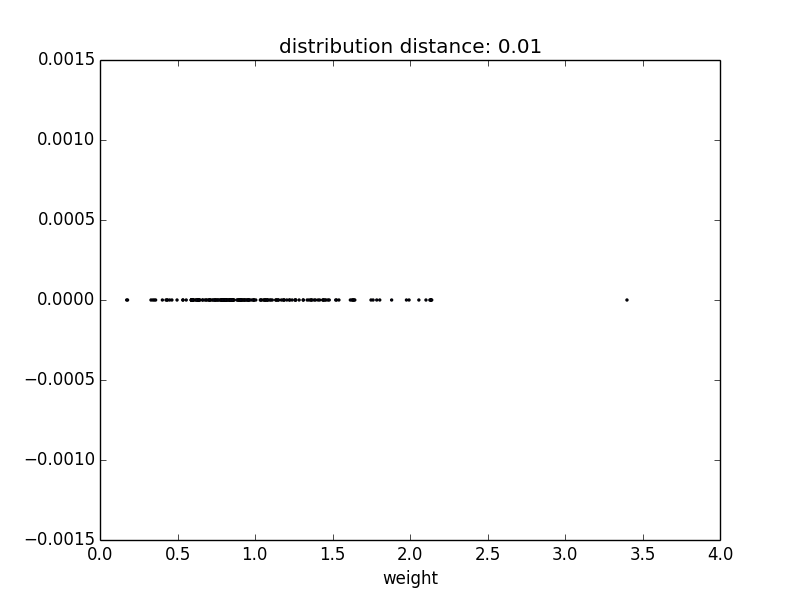

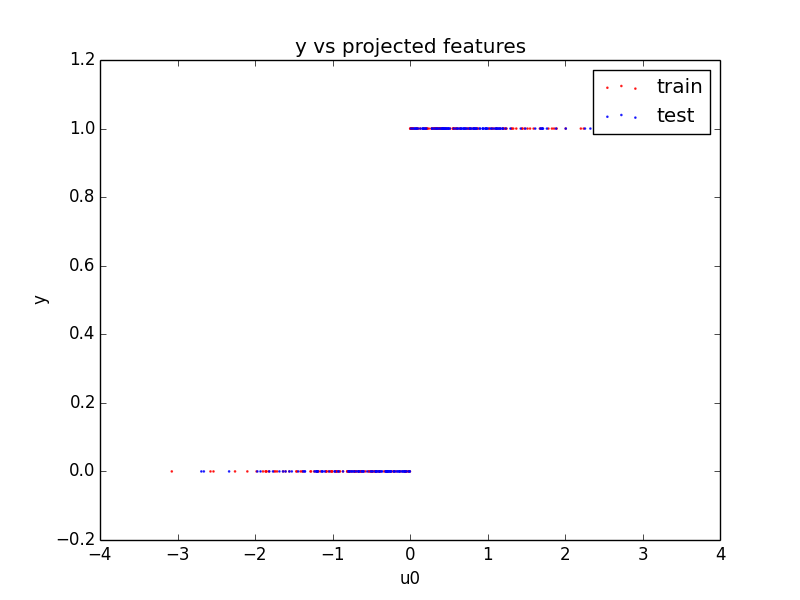

test_P: [[ 0.4472136 ]
 [ 0.89442719]] obj_val: 98.411055552


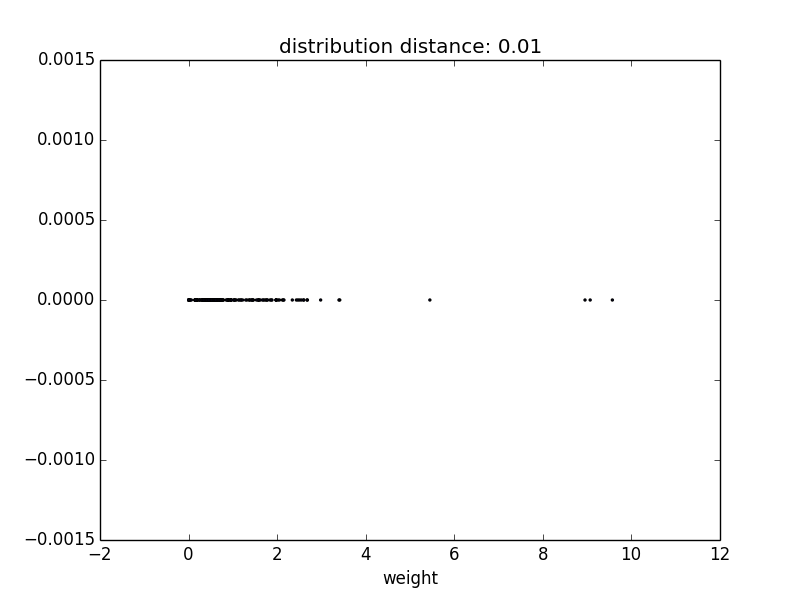

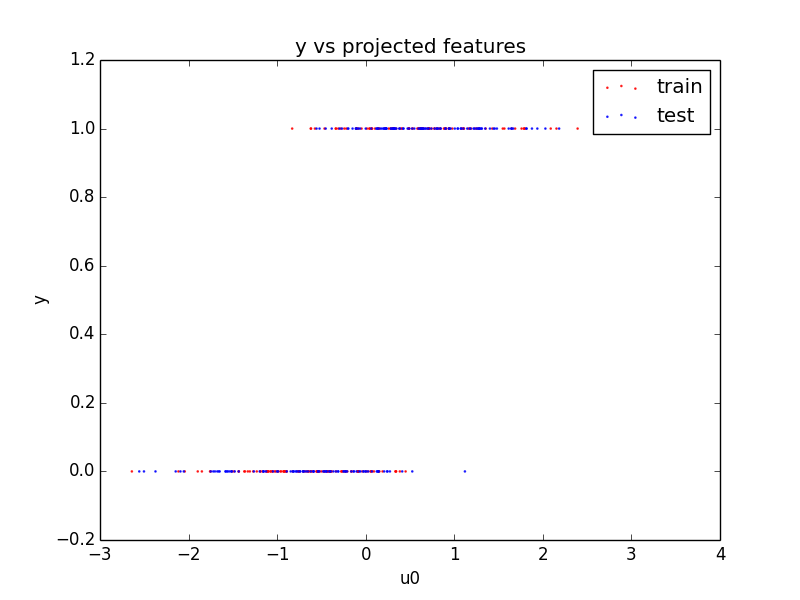

test_P: [[ 0.89442719]
 [ 0.4472136 ]] obj_val: 135.774673421


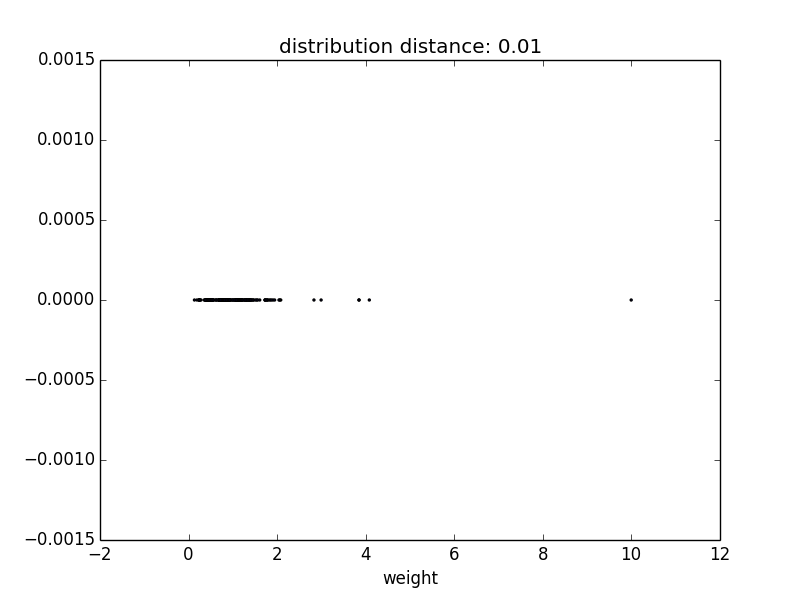

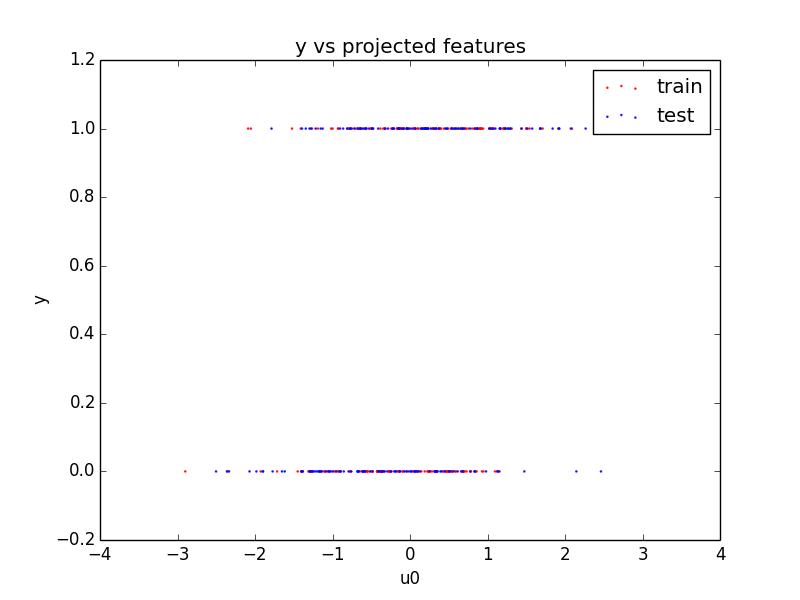

test_P: [[ 1.]
 [ 0.]] obj_val: 138.362161028


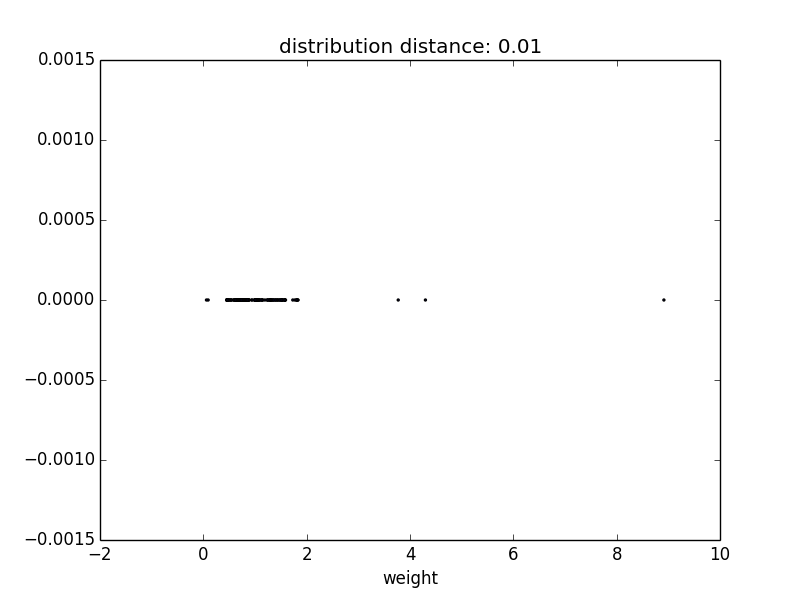

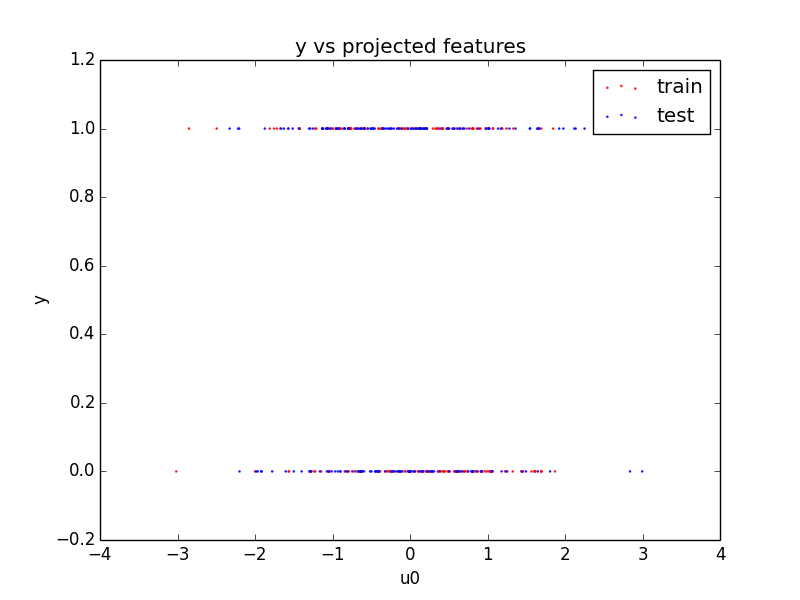

In [36]:
# set the kernels for this testing, based on a fixed P, to get a fixed objective fxn (and gradient)
#for_test_P = kernels.ortho(np.random.normal(size=(x_dim,desired_dim)))
for_test_P = kernels.ortho(np.array([[1,1]]).T)
test_SDR_get_K = get_SDR_get_K(for_test_P, 0)
test_SDR_get_Ky = get_SDR_get_Ky(for_test_P, 0)
test_KMM_get_K = get_KMM_get_K(for_test_P, 0)
print 'test KMM sigma:', test_KMM_get_K.args[0]
test_obj, test_dobj_dP = get_obj_and_dobj_dP(test_KMM_get_K, test_SDR_get_K, test_SDR_get_Ky)
cs = np.linspace(0,1,4)
for c in cs:
    test_P = kernels.ortho(np.array([(1.-c) * u_bases[:,0] + c * u_perp_bases[:,0]]).T)
    print 'test_P:', test_P, 'obj_val:', test_obj(test_P)
    kernels.plot_weights(xs_train, xs_test, test_KMM_get_K, B_max, KMM_eps, test_P)
    kernels.plot_y_vs_u(xs_train, ys_train, test_P, xs_test, ys_test, (x_low,x_high), (y_low,y_high))

In [37]:
#assert False

## optimize

In [38]:
#
def plot_optimize(optimize_info):
    kernels.plot_opt_log(optimize_info)

In [39]:
# define optimizer
def optimize(plot_optimize, manifold, solver, obj, dobj_dP, P_init):
    from pymanopt import Problem
    problem = pymanopt.Problem(manifold=manifold, cost=obj, egrad=dobj_dP, verbosity=0)
    P_fit, optimize_info = solver.solve(problem, x=P_init)
    print 'plot_optimize'
    plot_optimize(optimize_info)
    return P_fit, optimize_info
from pymanopt.solvers import SteepestDescent
from pymanopt.manifolds import Stiefel
solver = pymanopt.solvers.SteepestDescent(logverbosity=2)
manifold = pymanopt.manifolds.Stiefel(x_dim, u_dim)
plot_opt_info = lambda opt_log: None
optimizer = functools.partial(optimize, plot_optimize, manifold, solver)

In [40]:
#
def plot_anneal_step_state(obj, dobj_dP, KMM_get_K, SDR_get_K, SDR_get_Ky, P):
    kernels.plot_weights(xs_train, xs_test, KMM_get_K, B_max, KMM_eps, P)
    kernels.plot_K(xs_train, xs_train, KMM_get_K, P, 'KMM train train')
    kernels.plot_K(xs_train, xs_test, KMM_get_K, P, 'KMM train test')
    kernels.plot_K(xs_train, xs_train, SDR_get_K, P, 'SDR train train')
    kernels.gradient_check(obj, dobj_dP, P)
    kernels.plot_train_vs_test(xs_train, xs_test, P)
    print 'obj_val:', obj(P)
    kernels.plot_y_vs_u(xs_train, ys_train, P, xs_test, ys_test, (x_low,x_high), (y_low,y_high))
    
def plot_anneal_step(obj, dobj_dP, KMM_get_K, SDR_get_K, SDR_get_Ky, P, opt_log):
    plot_anneal_step_state(obj, dobj_dP, KMM_get_K, SDR_get_K, SDR_get_Ky, P)
    print 'annealing step P:', opt_log['final_values']['x'], opt_log['final_values']['f(x)']

In [41]:
# 
def plot_anneal(anneal_info):
    obj_val, anneal_step_infos = anneal_info
    fig, ax = plt.subplots()
    ax.scatter(range(len(anneal_step_infos)), [anneal_step_info[2].args[0] for anneal_step_info in anneal_step_infos])
    ax.set_title('KMM sigma')
    ax.set_xlabel('annealing step')
    ax.set_ylabel('sigma')
    basic.display_fig_inline(fig)

In [42]:
# 
def anneal(plot_anneal, plot_anneal_step, num_anneals, optimizer, get_KMM_get_K, get_SDR_get_K, get_SDR_get_Ky, get_obj_and_dobj_dP, P):
    anneal_step_infos = [] # store the things that change
    for step in xrange(num_anneals):
        KMM_get_K = get_KMM_get_K(P,step)
        SDR_get_K = get_SDR_get_K(P,step)
        SDR_get_Ky = get_SDR_get_Ky(P,step)
        obj, dobj_dP = get_obj_and_dobj_dP(KMM_get_K, SDR_get_K, SDR_get_Ky)
        
        print 'plot_anneal_step_state'
        plot_anneal_step_state(obj, dobj_dP, KMM_get_K, SDR_get_K, SDR_get_Ky, P)
        
        P, opt_log = optimizer(obj, dobj_dP, P)
        anneal_step_info = obj, dobj_dP, KMM_get_K, SDR_get_K, SDR_get_Ky, P, opt_log
        plot_anneal_step(*anneal_step_info)
        anneal_step_infos.append(anneal_step_info)
    anneal_info = (obj(P), anneal_step_infos)
    print 'plot_anneal'
    plot_anneal(anneal_info)
    return P, anneal_info
num_anneals = 1
annealer = functools.partial(anneal, plot_anneal, plot_anneal_step, num_anneals, optimizer, get_KMM_get_K, get_SDR_get_K, get_SDR_get_Ky, get_obj_and_dobj_dP)

In [43]:
#
def plot_multiples(multiples_info):
    obj_vals = []
    best_obj_val = None
    best_anneal_step_info = None
    for anneal_info in multiples_info:
        obj_val, anneal_step_infos = anneal_info
        obj, dobj_dP, KMM_get_K, SDR_get_K, SDR_get_Ky, P, opt_log = anneal_step_infos[-1]
        print 'this anneal obj_val:', obj_val, 'P:', P
        kernels.plot_y_vs_u(xs_train, ys_train, P, xs_test, ys_test, (x_low,x_high), (y_low,y_high))
        obj_vals.append(obj_val)
        if obj_val > best_obj_val:
            best_obj_val = obj_val
            best_anneal_step_info = anneal_step_infos[-1]
    #plot_anneal_step(*best_anneal_step_info)
    print 'obj_vals', obj_vals

In [44]:
#
def multiples(plot_multiples, num_trials, annealer, P_shape):
    trial_infos = []
    best_P = None
    best_obj_val = None
    for i in xrange(num_trials):
        P_init = kernels.ortho(np.random.normal(size=P_shape))
        P, anneal_info = annealer(P_init)
        trial_infos.append(anneal_info)
        (obj_val, anneal_step_infos) = anneal_info
        if best_P is None or obj_val < best_obj_val:
            best_P = P
            best_obj_val = obj_val
    multiples_info = trial_infos
    plot_multiples(multiples_info)

plot_anneal_step_state


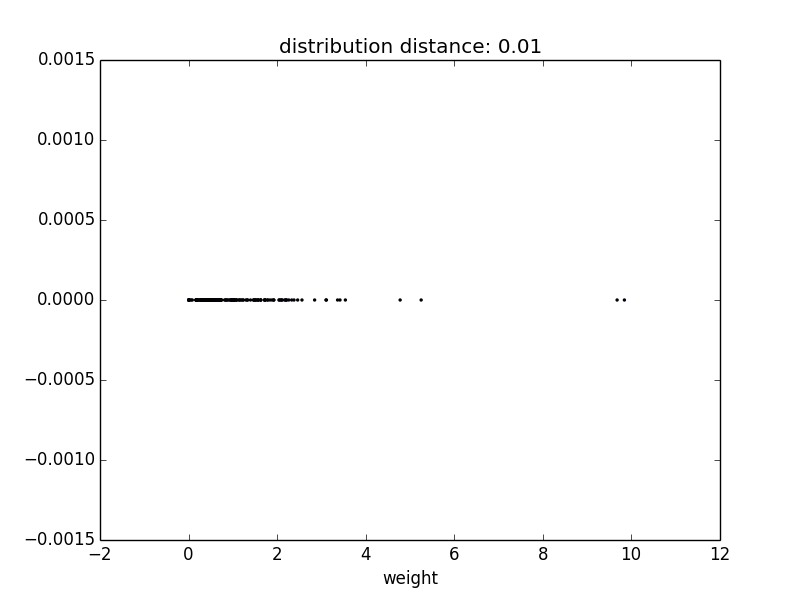

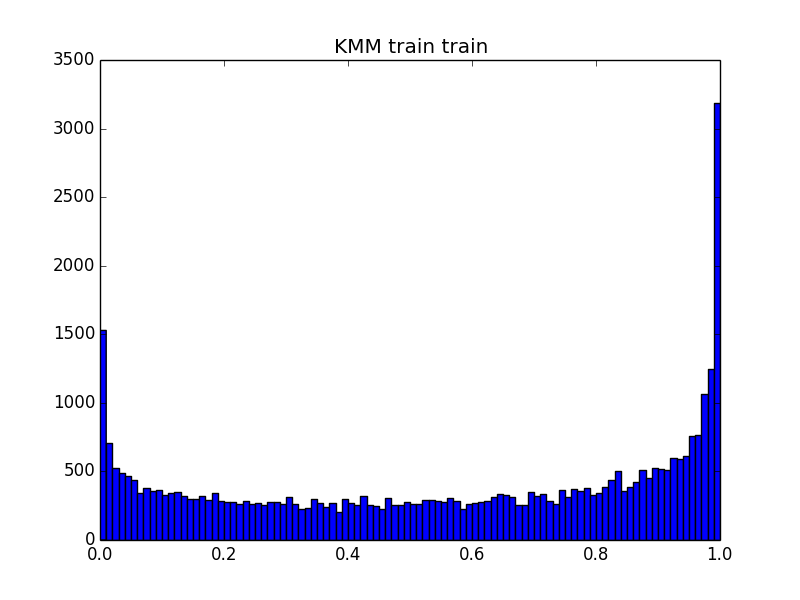

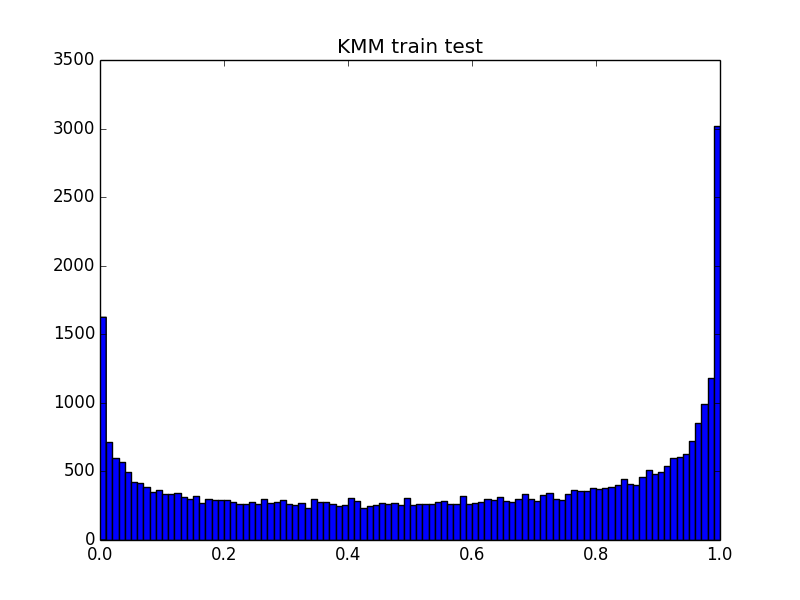

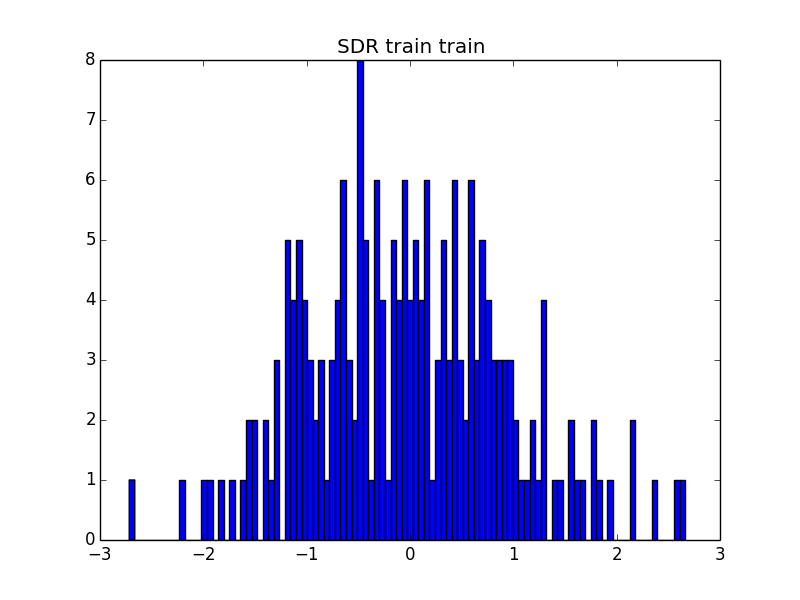

numerical gradient:
[[ 39.82146399]
 [-15.37800058]]
analytical gradient:
L_args len: 2
L_args len: 2
num_tight: 0
solver error: 0.0
num_tight: 0
solver error: 3.30191174988
L_args len: 2
num_tight: 0
solver error: 0.0
[[ 60.5132742 ]
 [-27.39479053]]


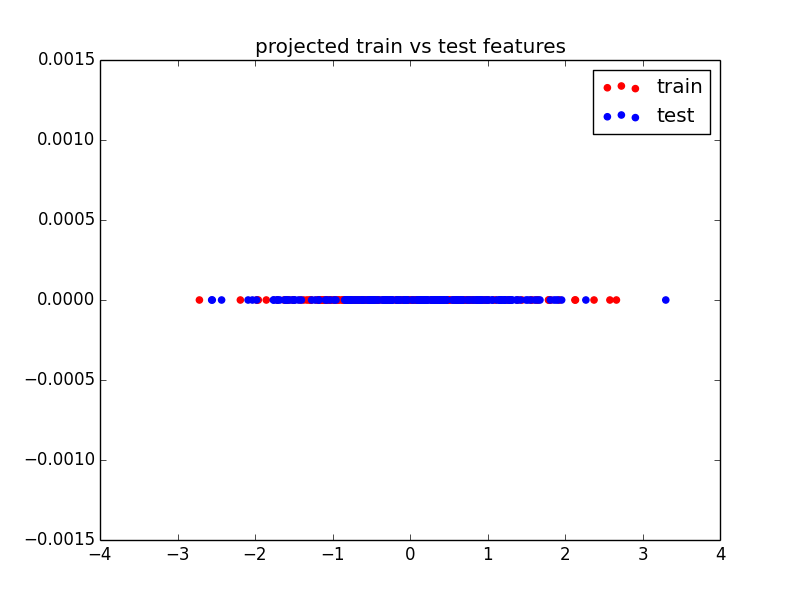

obj_val: 95.3335044353


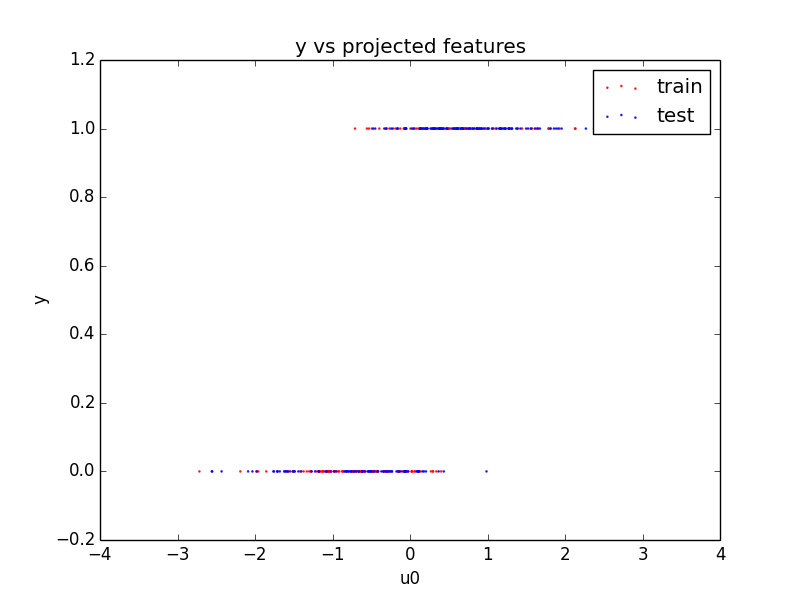

L_args len: 2
L_args len: 2
num_tight: 0
solver error: 1.32348898008e-23
num_tight: 0
solver error: 3.30191174984
L_args len: 2
num_tight: 0
solver error: 0.0
L_args len: 2
L_args len: 2
num_tight: 0
solver error: 0.0
num_tight: 0
solver error: 3.343844064
L_args len: 2
num_tight: 0
solver error: 0.0
L_args len: 2
L_args len: 2
num_tight: 0
solver error: 0.0
num_tight: 0
solver error: 2.36999875799
L_args len: 2
num_tight: 0
solver error: 1.05879118407e-22
L_args len: 2
L_args len: 2
num_tight: 0
solver error: 0.0
num_tight: 0
solver error: 1.84883646878
L_args len: 2
num_tight: 0
solver error: 0.0
L_args len: 2
L_args len: 2
num_tight: 0
solver error: 0.0
num_tight: 0
solver error: 0.940725911661
L_args len: 2
num_tight: 0
solver error: 1.05879118407e-22
L_args len: 2
L_args len: 2
num_tight: 0
solver error: 0.0
num_tight: 0
solver error: 0.858605759224
L_args len: 2
num_tight: 0
solver error: 0.0
L_args len: 2
L_args len: 2
num_tight: 0
solver error: 8.47032947254e-22
num_tight: 0
so

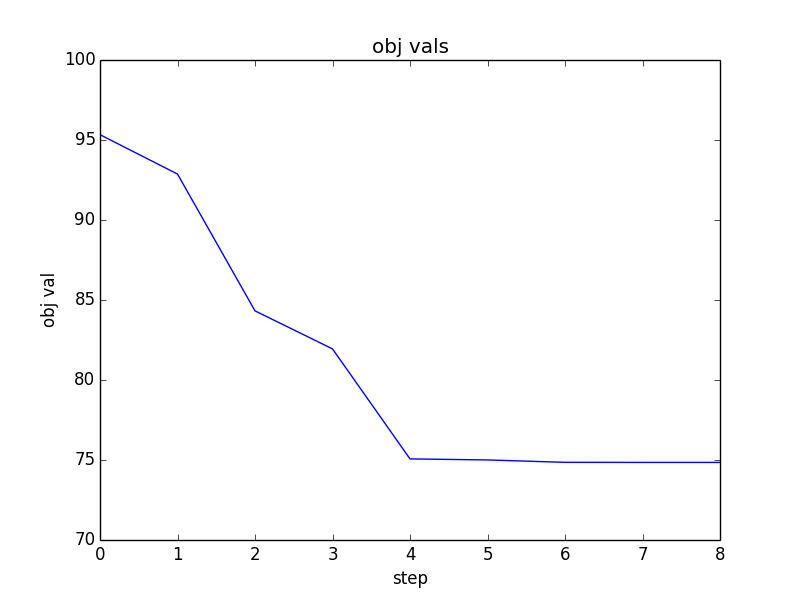

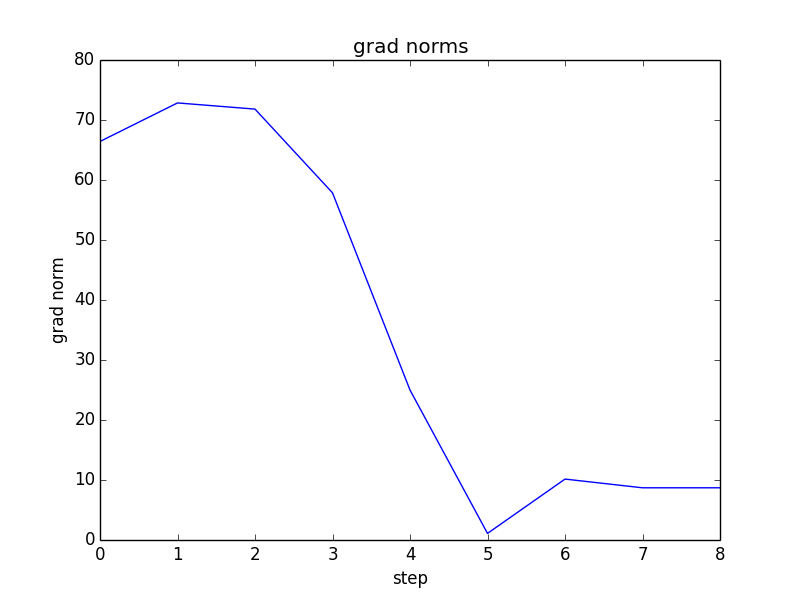

/Users/fultonw/Library/Enthought/Canopy_64bit/User/lib/python2.7/site-packages/matplotlib/pyplot.py:412: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_num_figures`).
  max_open_warning, RuntimeWarning)


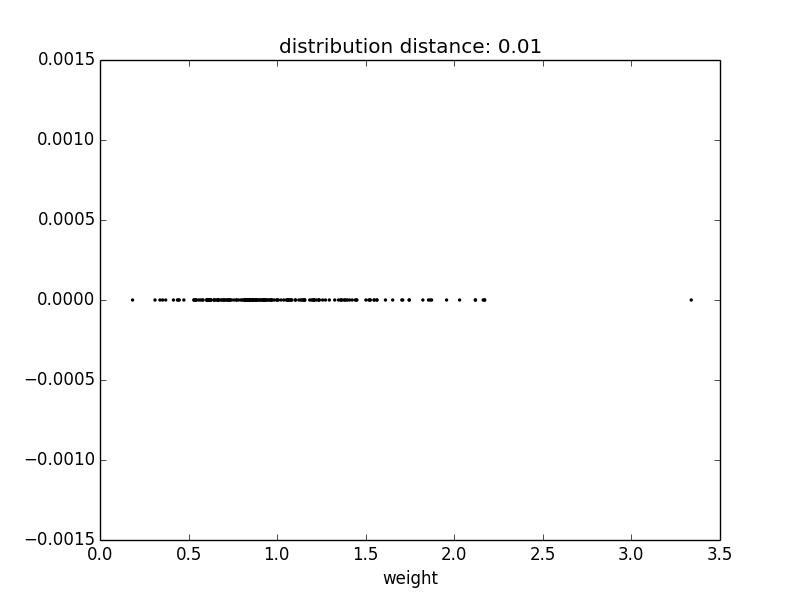

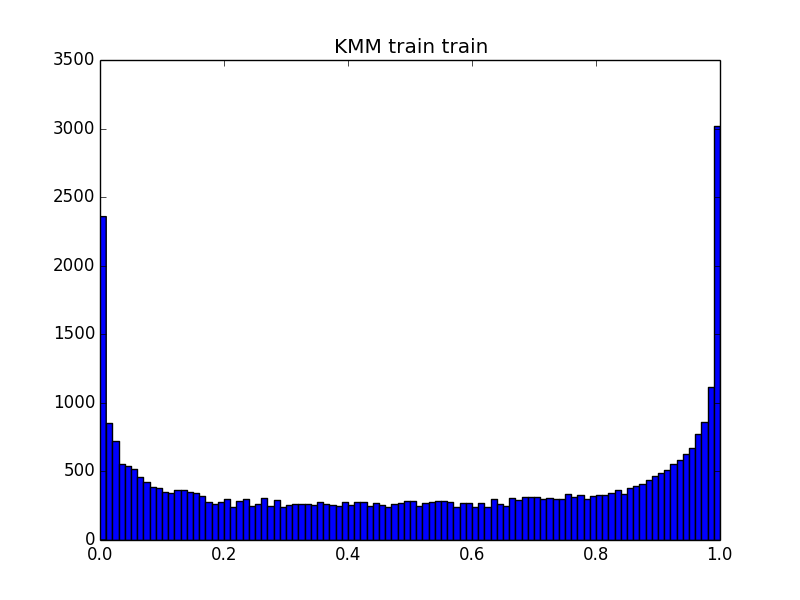

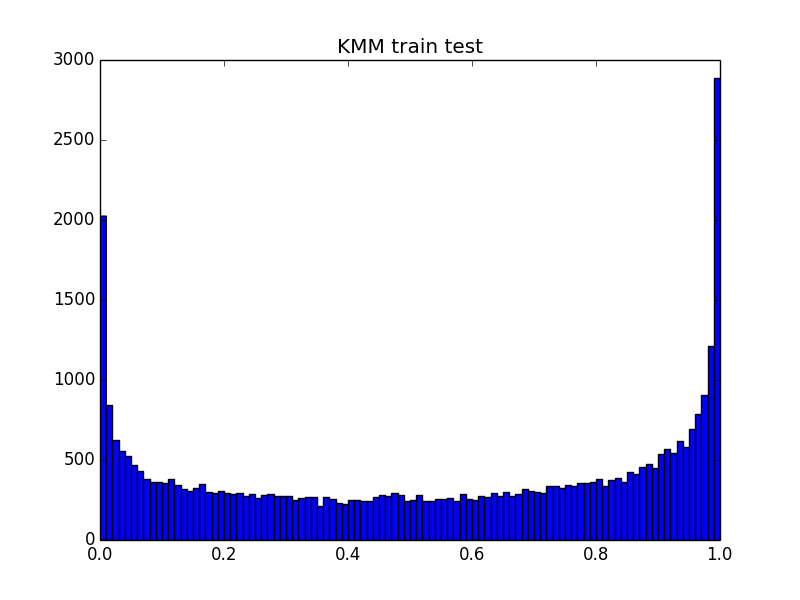

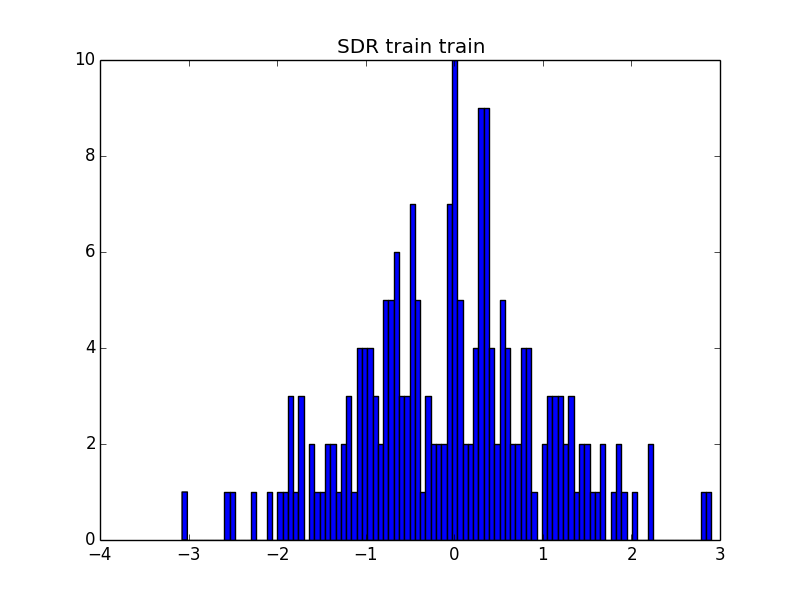

numerical gradient:
[[-0.83290116]
 [-7.0520106 ]]
analytical gradient:
L_args len: 2
L_args len: 2
num_tight: 0
solver error: 5.29395592034e-23
num_tight: 0
solver error: 0.845631829263
L_args len: 2
num_tight: 0
solver error: 0.0
[[ 8.69371015]
 [-6.84893461]]


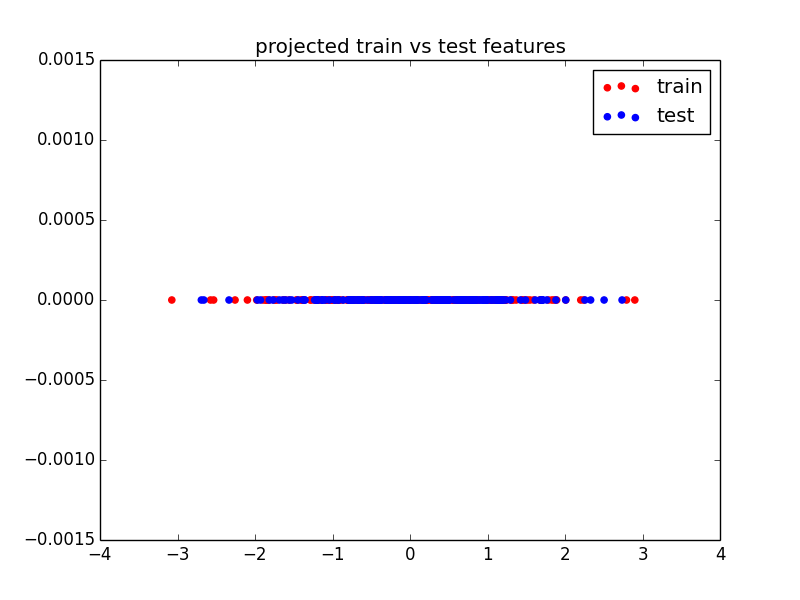

obj_val: 74.8492771067


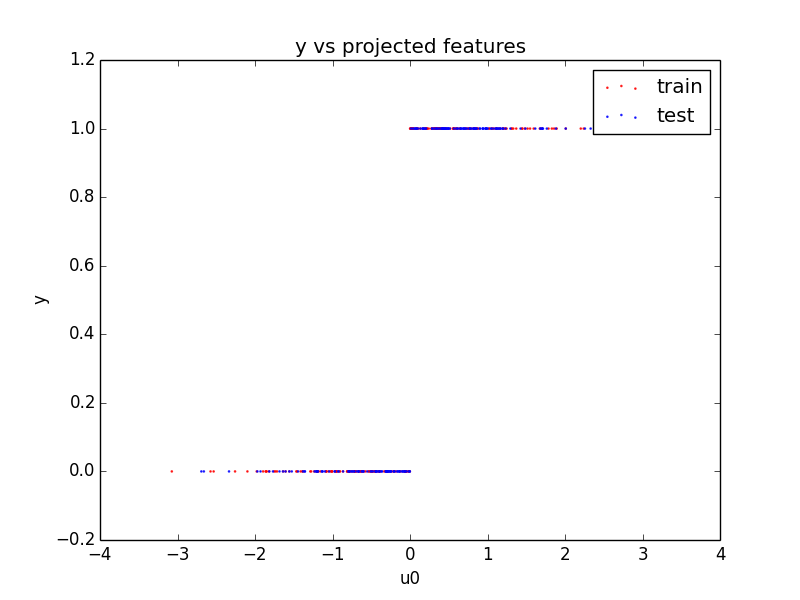

annealing step P: [[ 0.00108873]
 [ 0.99999941]] 74.8492771067
plot_anneal


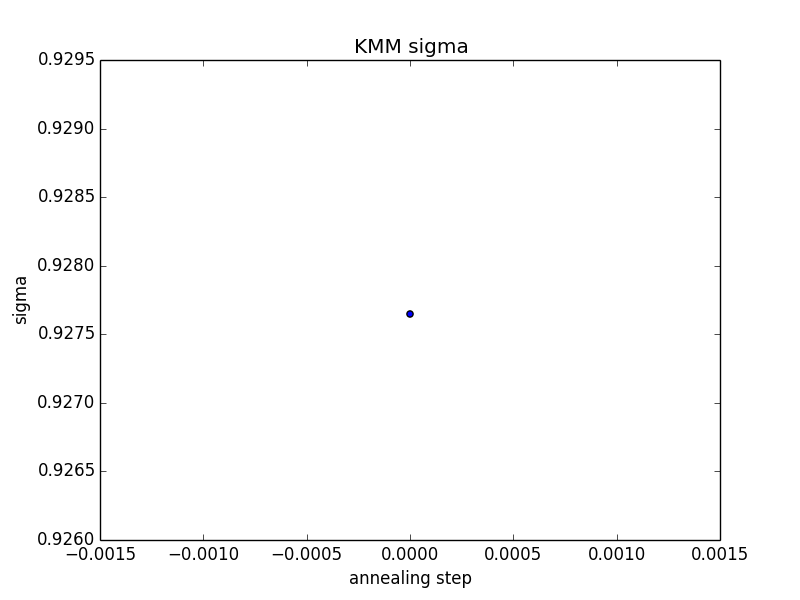

plot_anneal_step_state


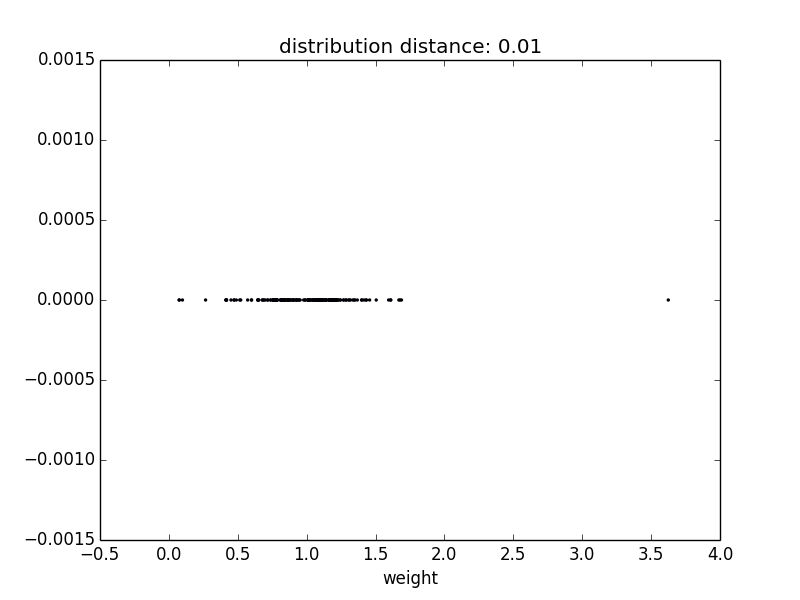

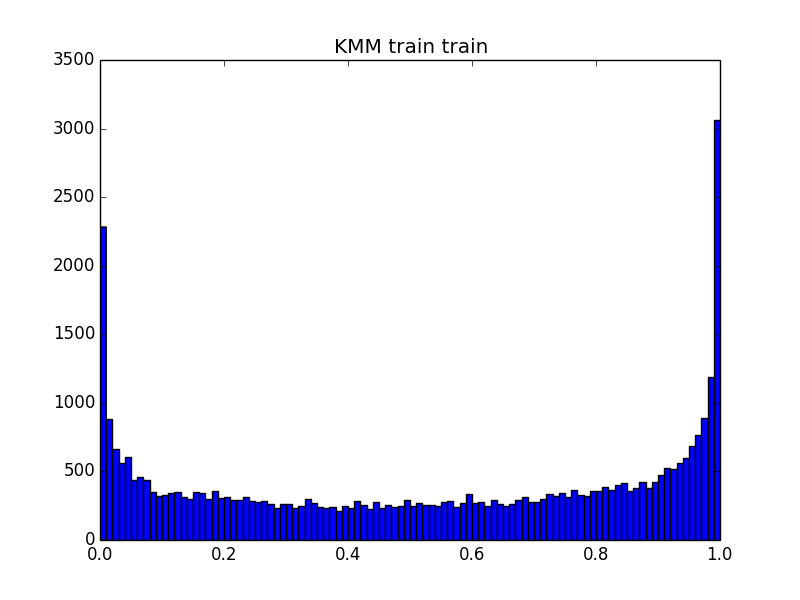

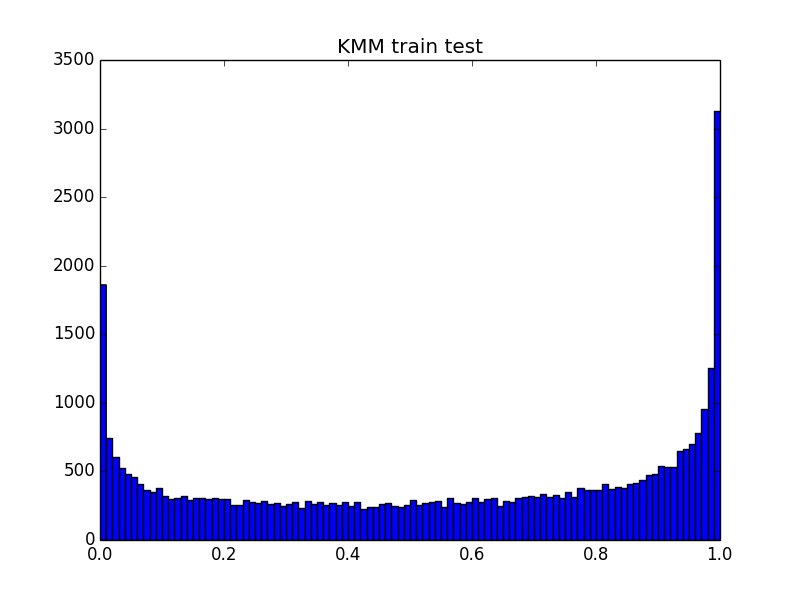

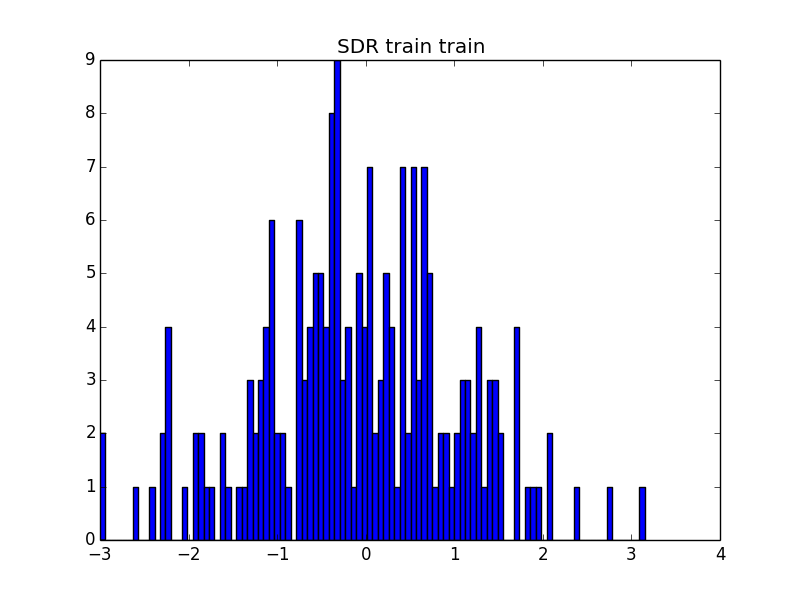

numerical gradient:
[[-59.43507704]
 [-23.13850295]]
analytical gradient:
L_args len: 2
L_args len: 2
num_tight: 0
solver error: 0.0
num_tight: 0
solver error: 3.0121326582
L_args len: 2
num_tight: 0
solver error: 5.29395592034e-23
[[-70.57636557]
 [-25.72658378]]


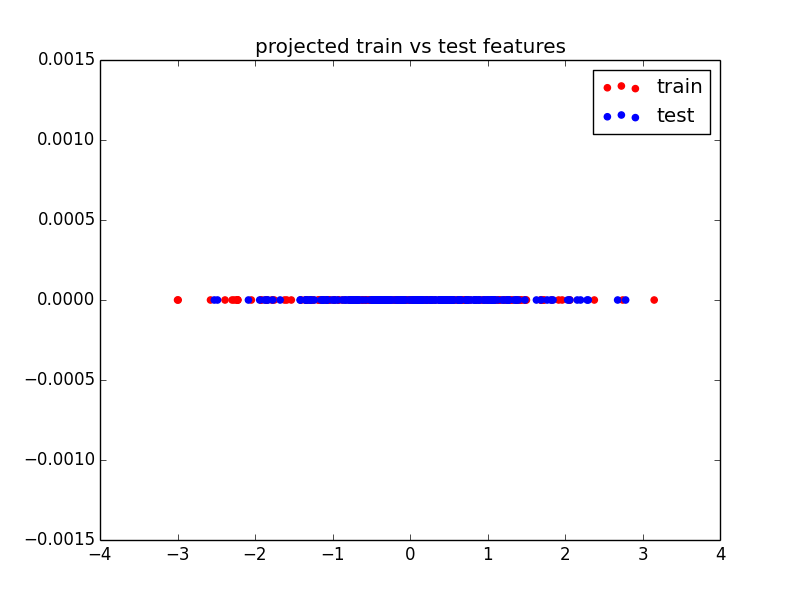

obj_val: 89.9457380086


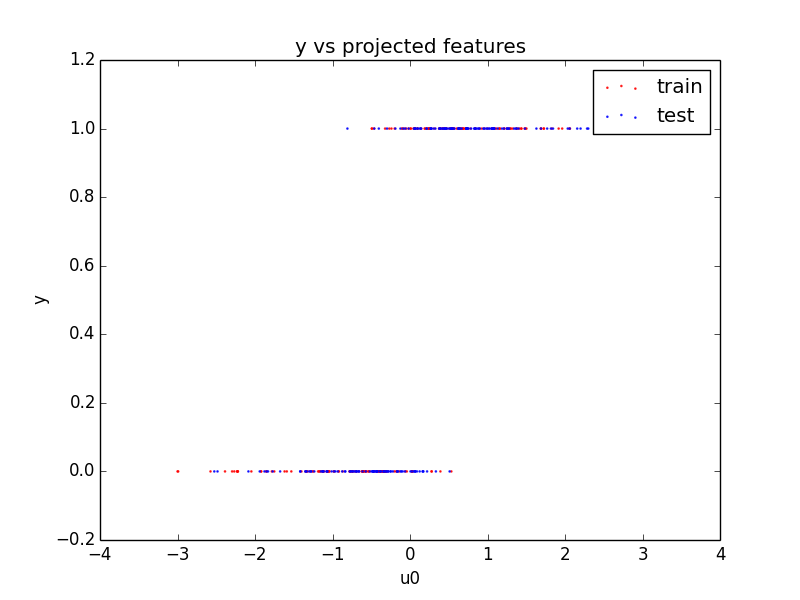

L_args len: 2
L_args len: 2
num_tight: 0
solver error: 0.0
num_tight: 0
solver error: 3.01213265821
L_args len: 2
num_tight: 0
solver error: 0.0
L_args len: 2
L_args len: 2
num_tight: 0
solver error: 0.0
num_tight: 0
solver error: 1.37914409053
L_args len: 2
num_tight: 0
solver error: 0.0
L_args len: 2
L_args len: 2
num_tight: 0
solver error: 0.0
num_tight: 0
solver error: 0.95871991762
L_args len: 2
num_tight: 0
solver error: 0.0
L_args len: 2
L_args len: 2
num_tight: 0
solver error: 2.11758236814e-22
num_tight: 0
solver error: 0.921678375633
L_args len: 2
num_tight: 0
solver error: 8.47032947254e-22
L_args len: 2
L_args len: 2
num_tight: 0
solver error: 3.30872245021e-24
num_tight: 0
solver error: 0.866882129664
L_args len: 2
num_tight: 0
solver error: 3.30872245021e-24
L_args len: 2
L_args len: 2
num_tight: 0
solver error: 0.0
num_tight: 0
solver error: 0.862208056485
L_args len: 2
num_tight: 0
solver error: 1.05879118407e-22
plot_optimize


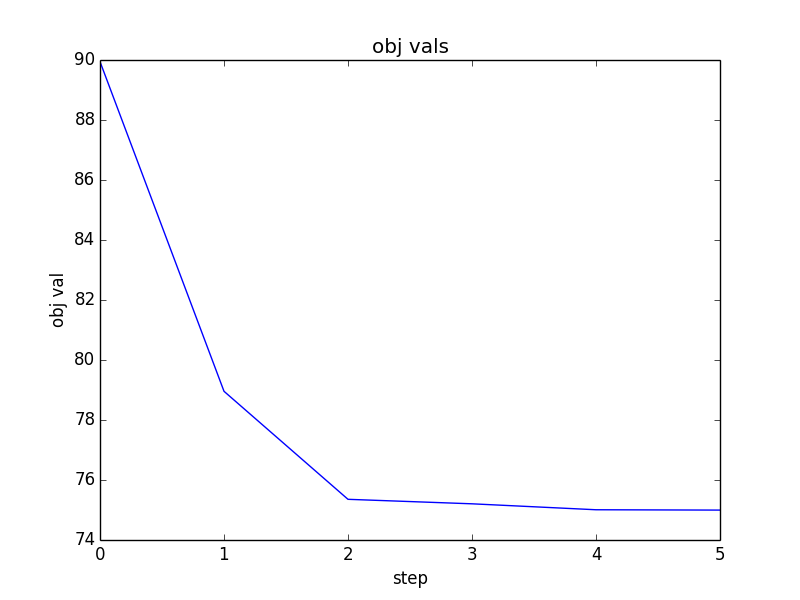

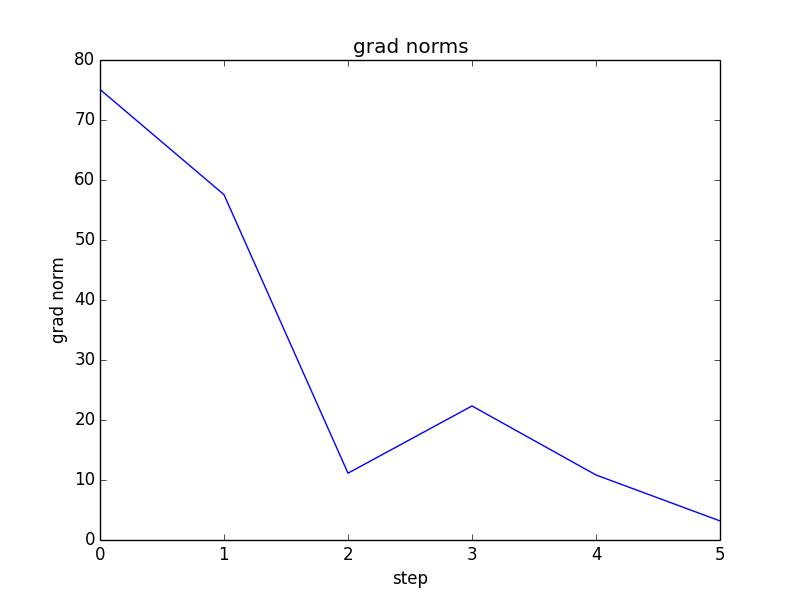

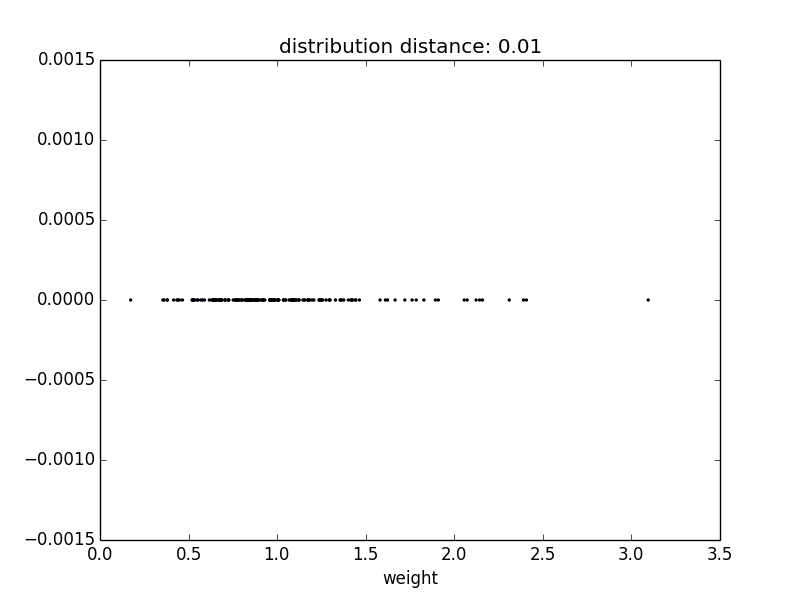

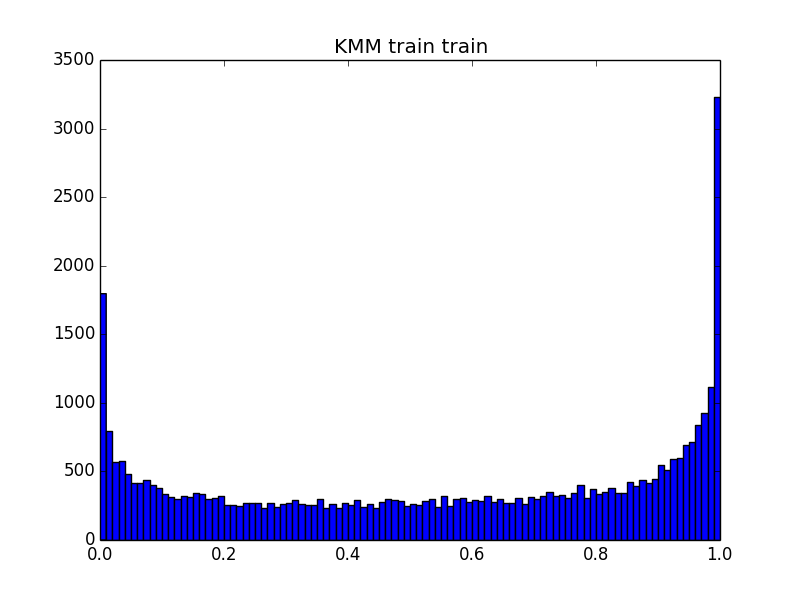

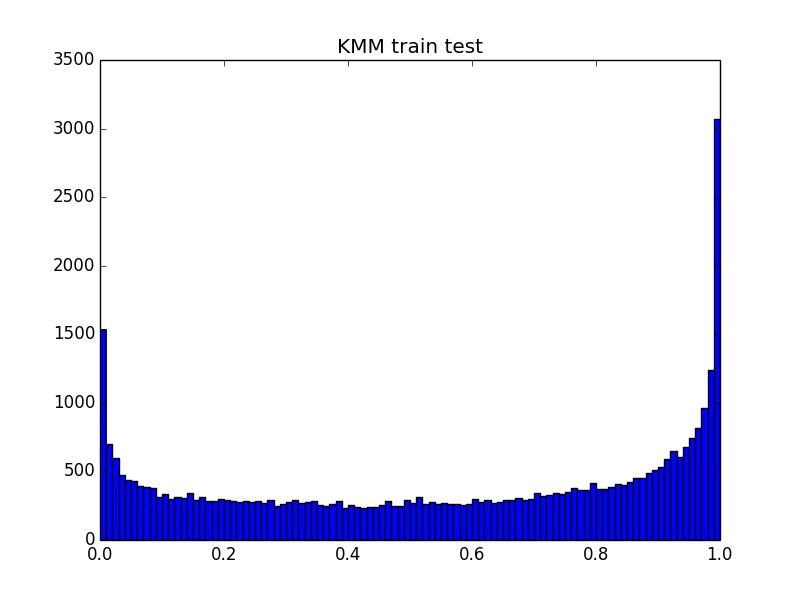

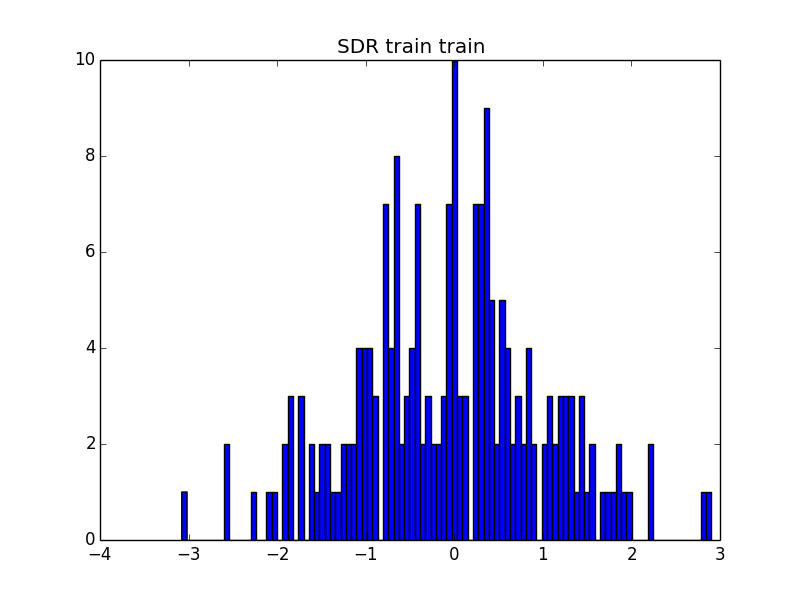

numerical gradient:
[[-1.63080376]
 [-7.6204795 ]]
analytical gradient:
L_args len: 2
L_args len: 2
num_tight: 0
solver error: 1.05879118407e-22
num_tight: 0
solver error: 0.862208138397
L_args len: 2
num_tight: 0
solver error: 0.0
[[ 3.27467943]
 [-6.81355874]]


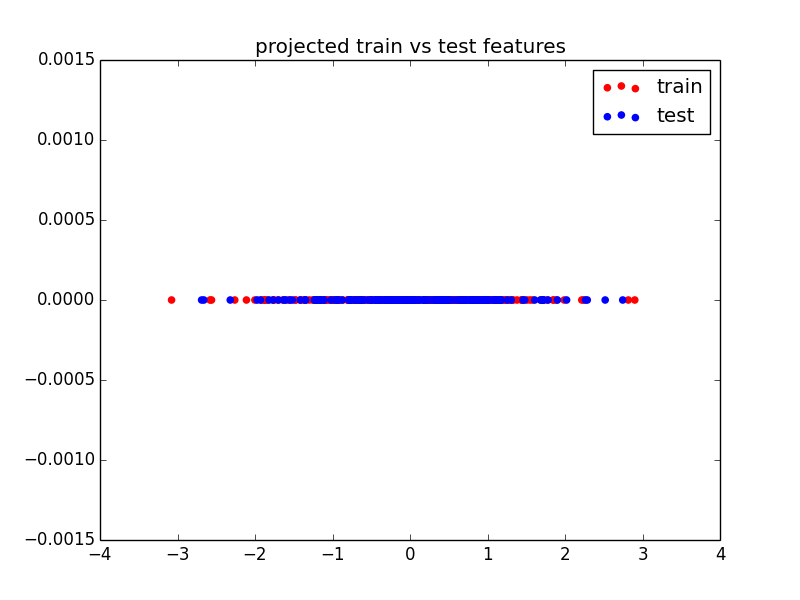

obj_val: 74.9969506875


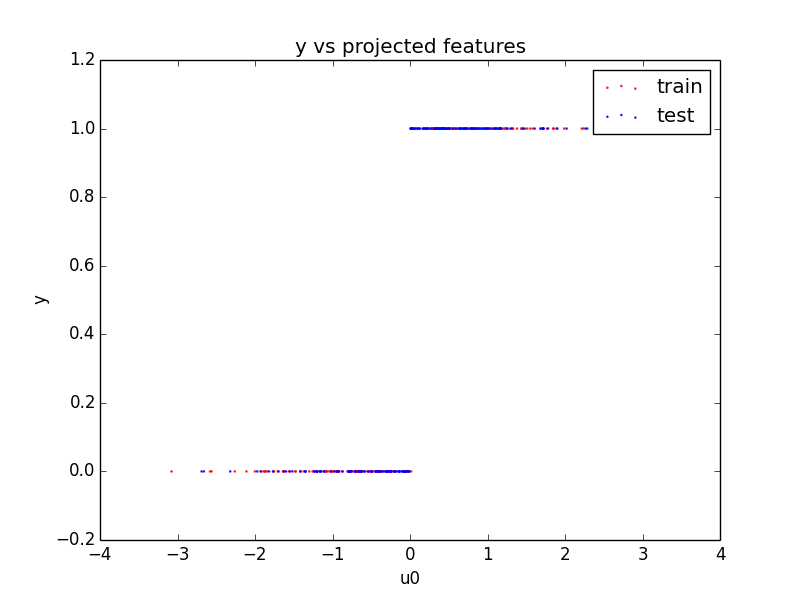

annealing step P: [[-0.01374082]
 [ 0.99990559]] 74.9969506875
plot_anneal


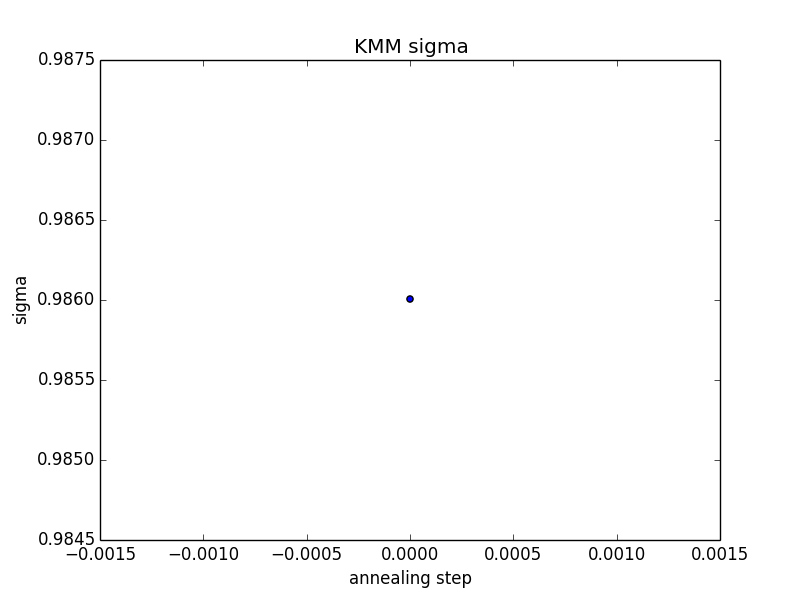

plot_anneal_step_state


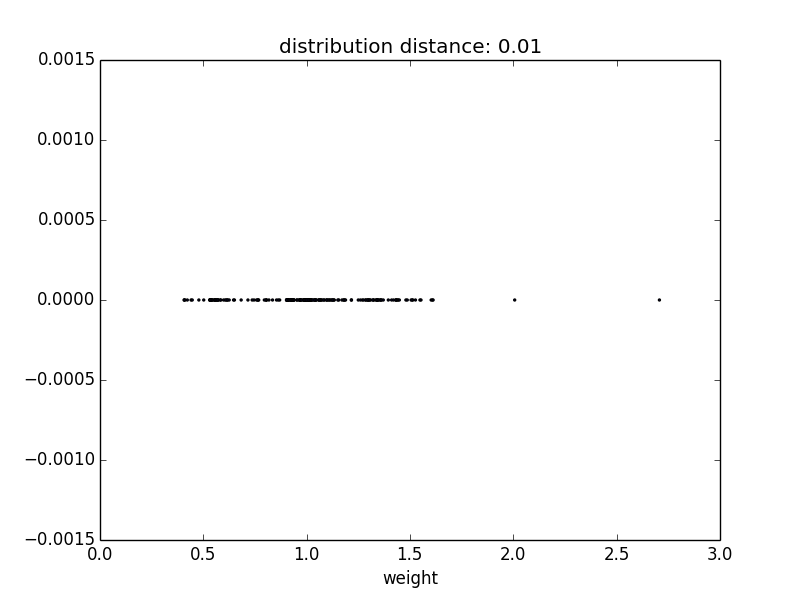

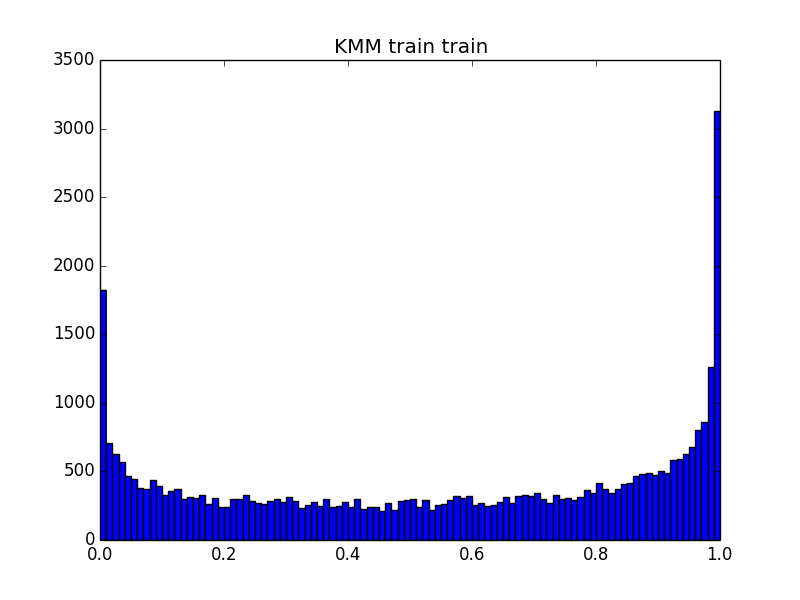

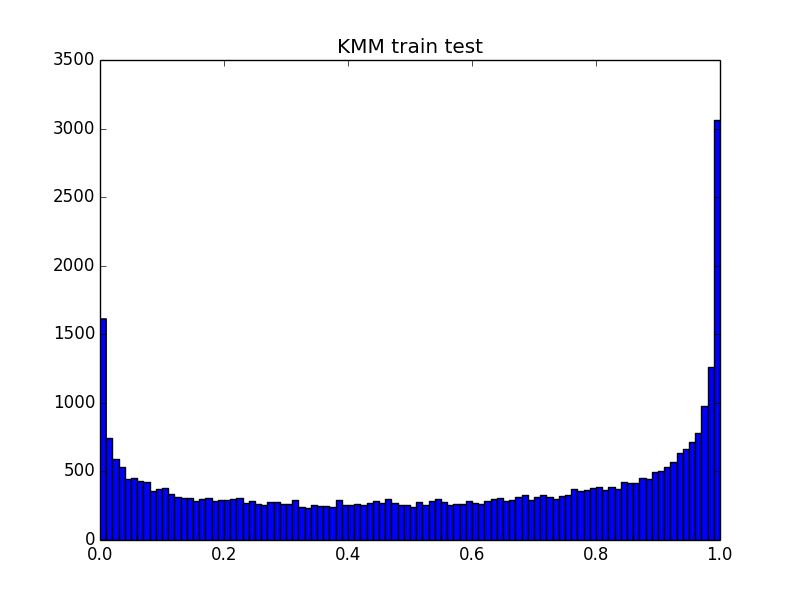

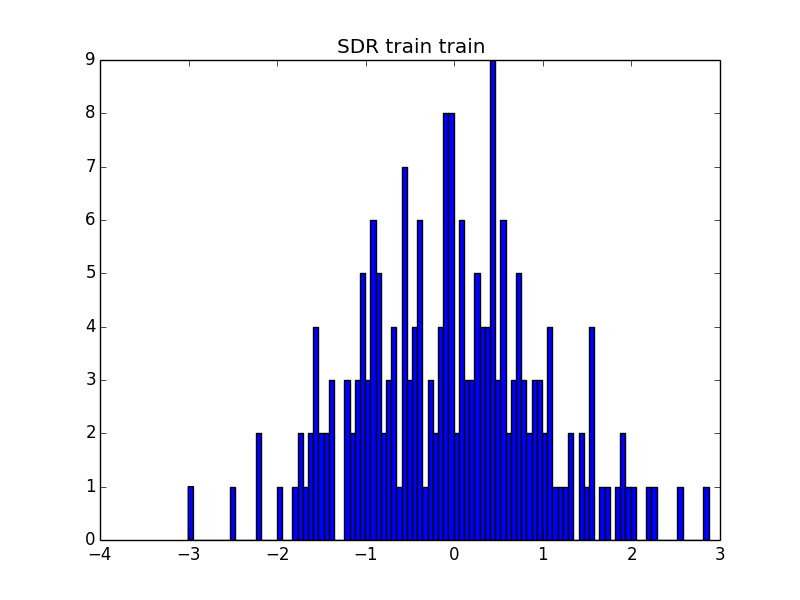

numerical gradient:
[[ 52.35410783]
 [-28.93419016]]
analytical gradient:
L_args len: 2
L_args len: 2
num_tight: 0
solver error: 0.0
num_tight: 0
solver error: 1.43370922293
L_args len: 2
num_tight: 0
solver error: 2.64697796017e-23
[[ 54.59322919]
 [-13.63081679]]


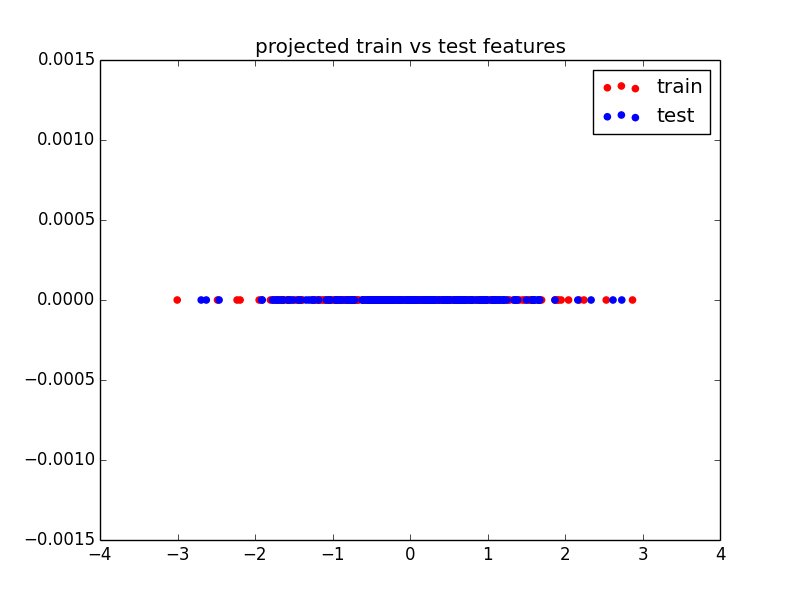

obj_val: 78.9921030778


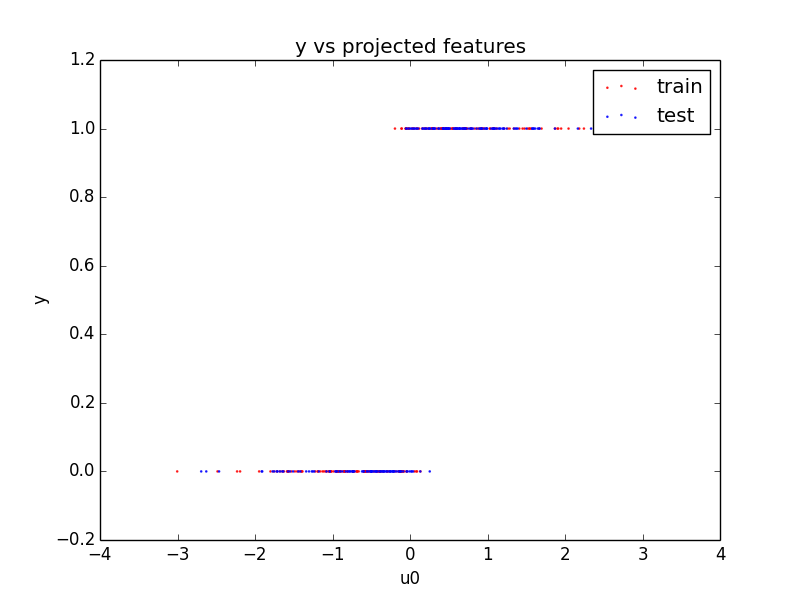

L_args len: 2
L_args len: 2
num_tight: 0
solver error: 0.0
num_tight: 0
solver error: 1.4337099678
L_args len: 2
num_tight: 0
solver error: 0.0
L_args len: 2
L_args len: 2
num_tight: 0
solver error: 0.0
num_tight: 0
solver error: 1.24921990279
L_args len: 2
num_tight: 0
solver error: 1.32348898008e-23
L_args len: 2
L_args len: 2
num_tight: 0
solver error: 0.0
num_tight: 0
solver error: 0.935241857698
L_args len: 2
num_tight: 0
solver error: 0.0
L_args len: 2
L_args len: 2
num_tight: 0
solver error: 0.0
num_tight: 0
solver error: 0.874902103222
L_args len: 2
num_tight: 0
solver error: 0.0
plot_optimize


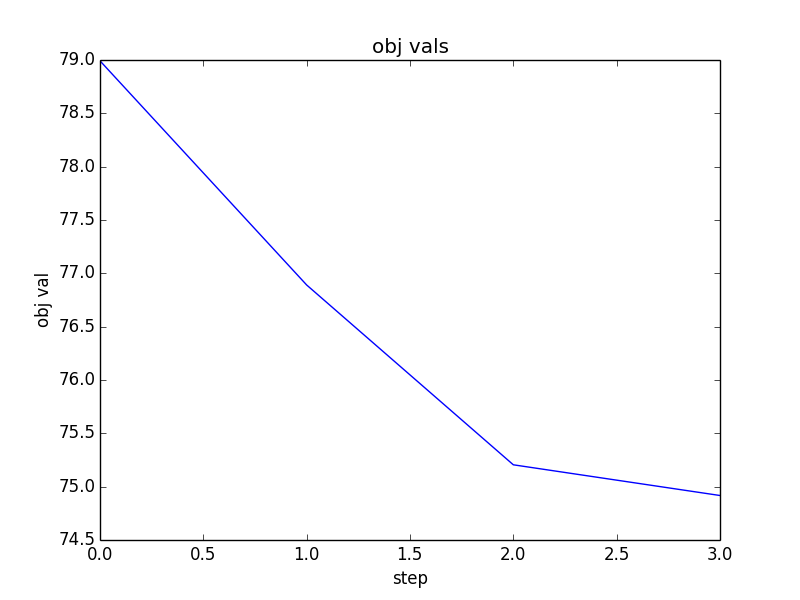

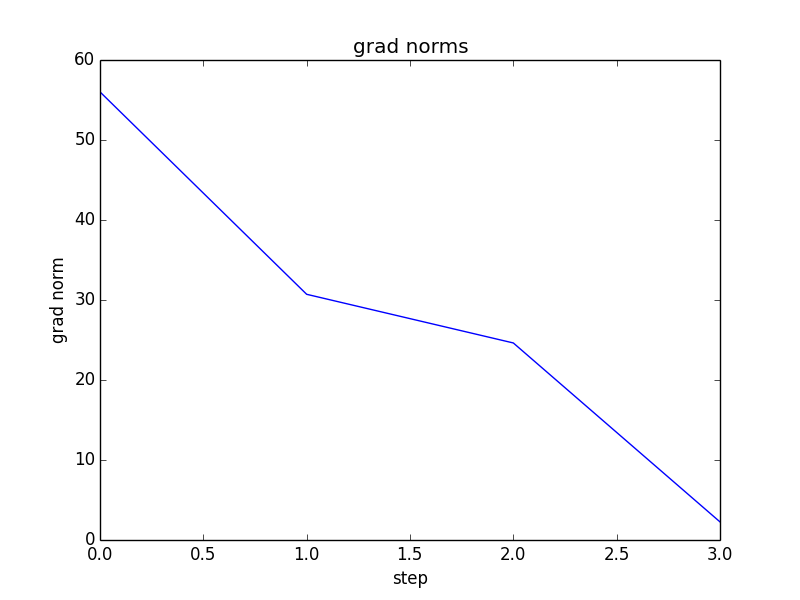

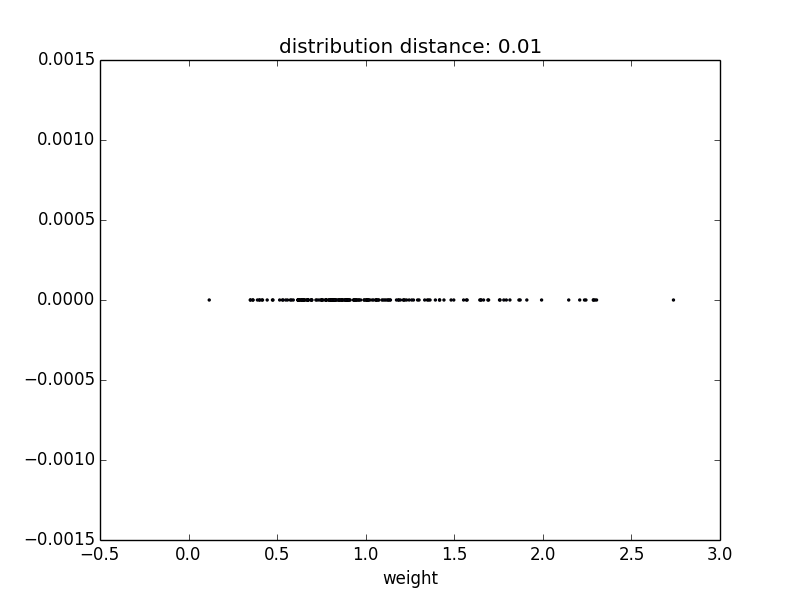

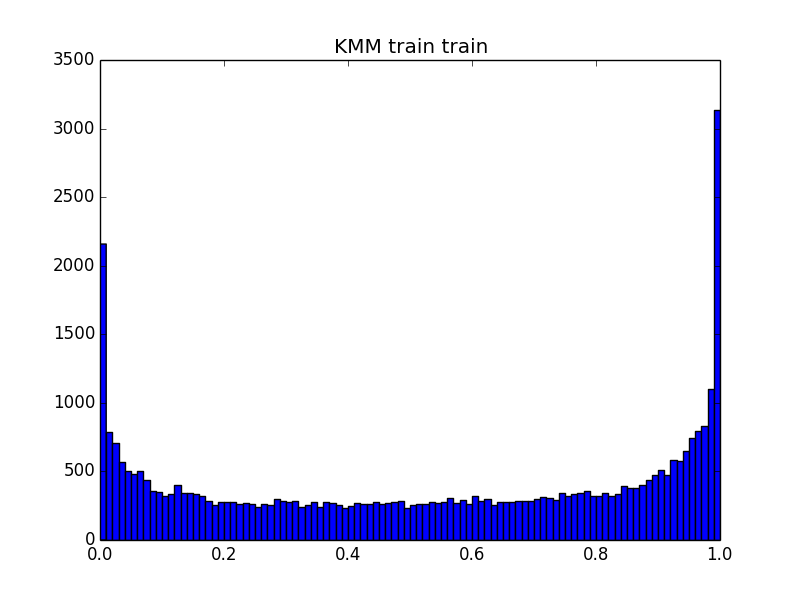

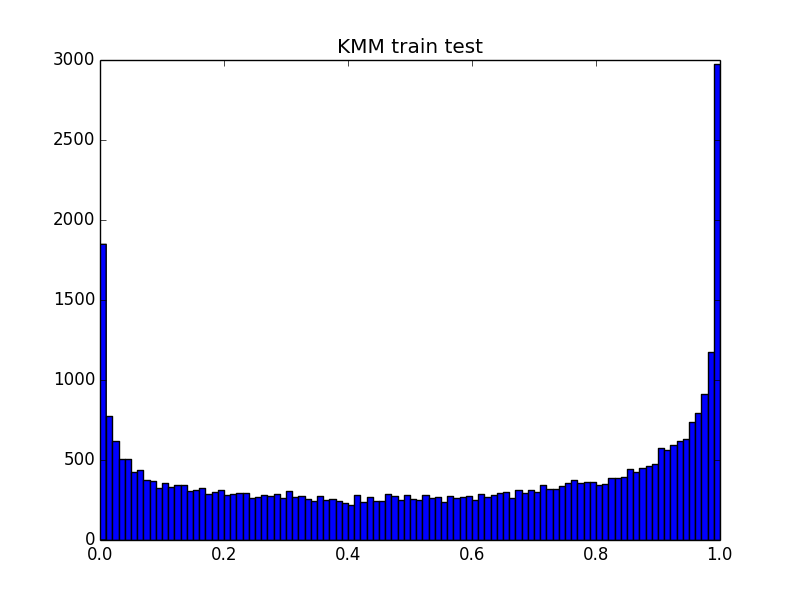

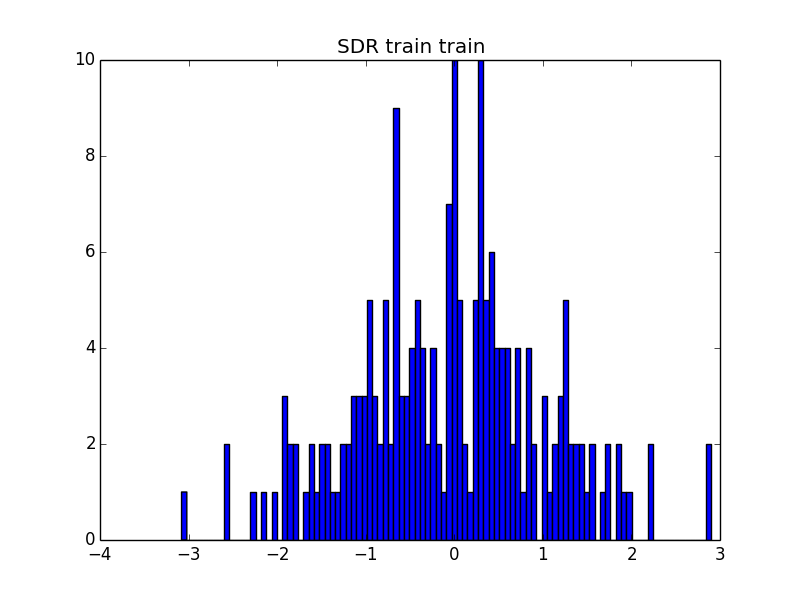

numerical gradient:
[[ 15.23146387]
 [-10.34592118]]
analytical gradient:
L_args len: 2
L_args len: 2
num_tight: 0
solver error: 0.0
num_tight: 0
solver error: 0.874902102786
L_args len: 2
num_tight: 0
solver error: 0.0
[[-2.07072362]
 [-6.71388709]]


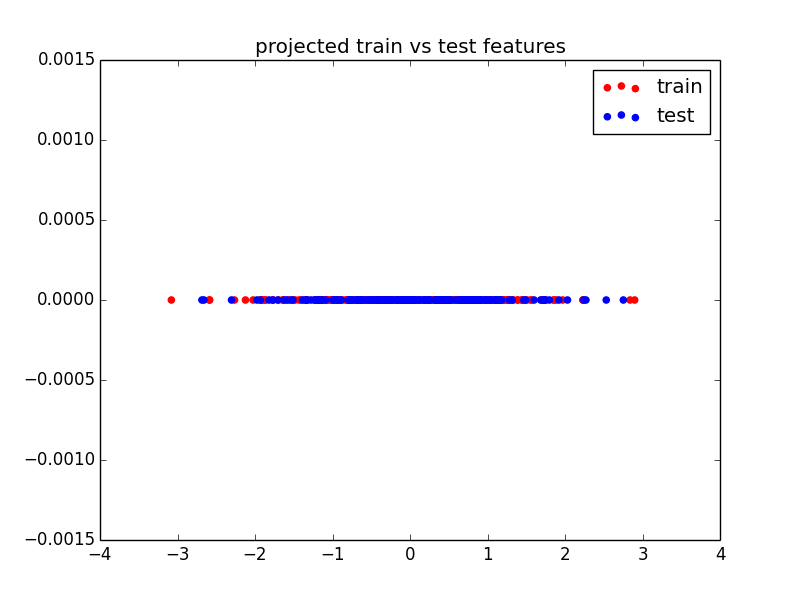

obj_val: 74.9171330282


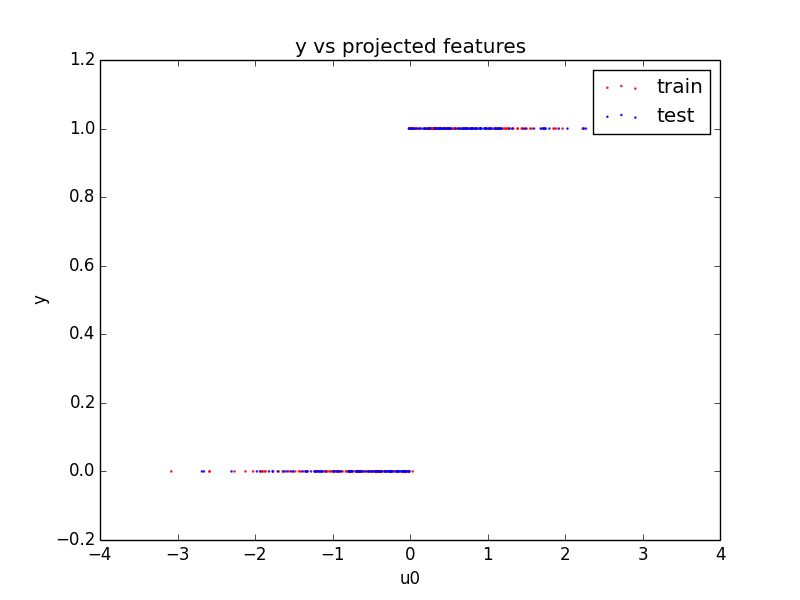

annealing step P: [[-0.02878282]
 [ 0.99958569]] 74.9171330282
plot_anneal


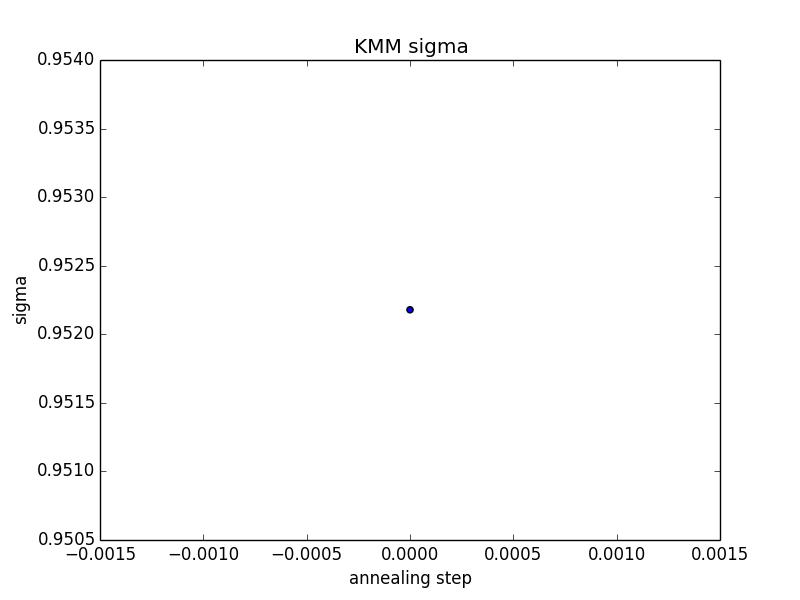

plot_anneal_step_state


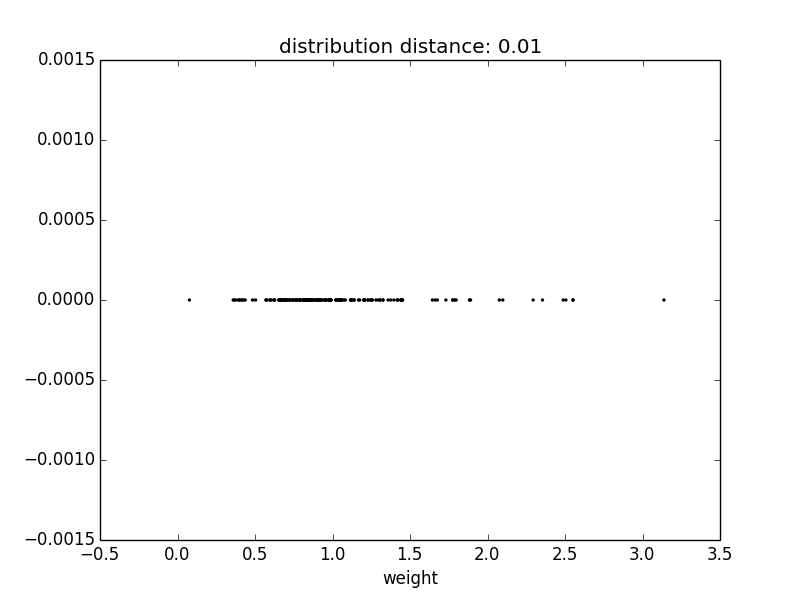

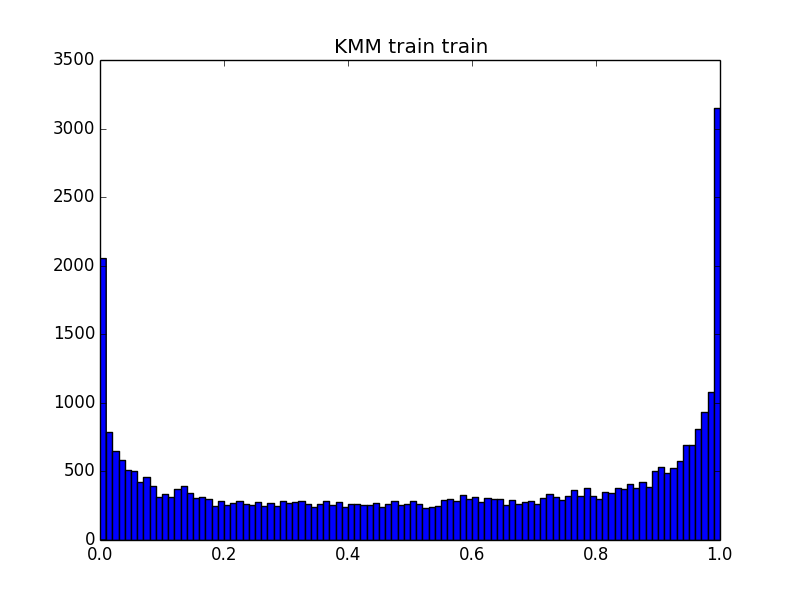

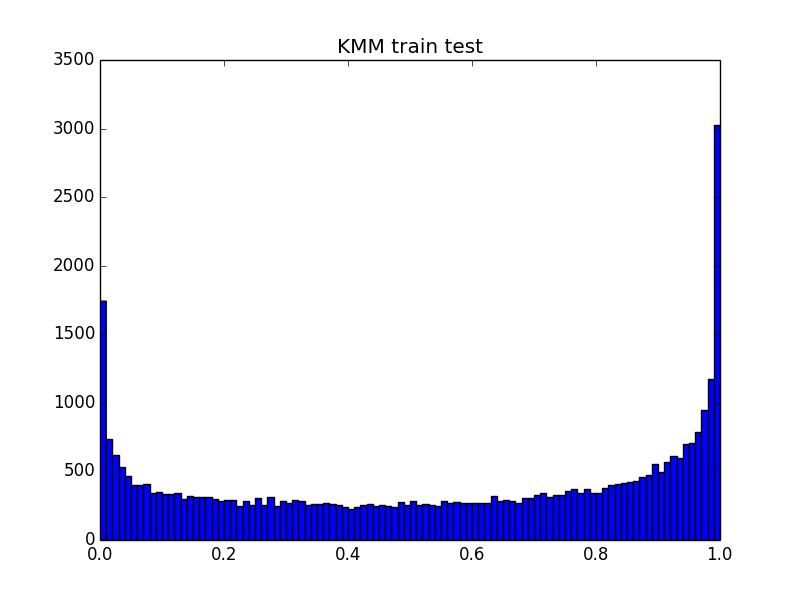

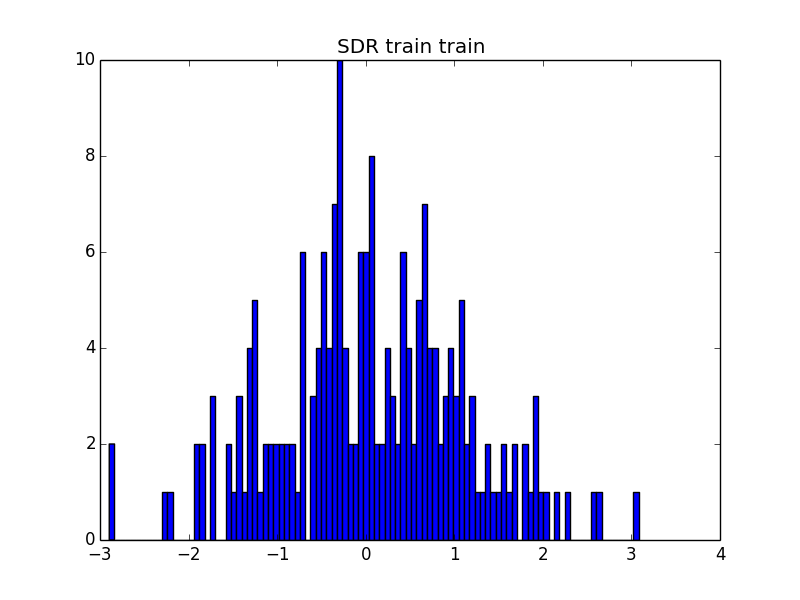

numerical gradient:
[[ 21.57674511]
 [  5.17873555]]
analytical gradient:
L_args len: 2
L_args len: 2
num_tight: 0
solver error: 0.0
num_tight: 0
solver error: 0.977031498422
L_args len: 2
num_tight: 0
solver error: 1.05879118407e-22
[[ 12.67888378]
 [  6.79349869]]


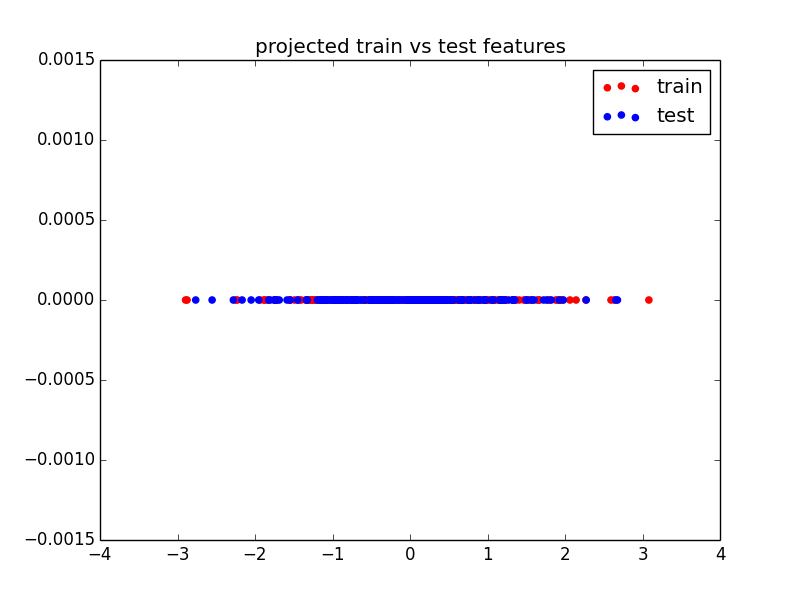

obj_val: 75.4894333258


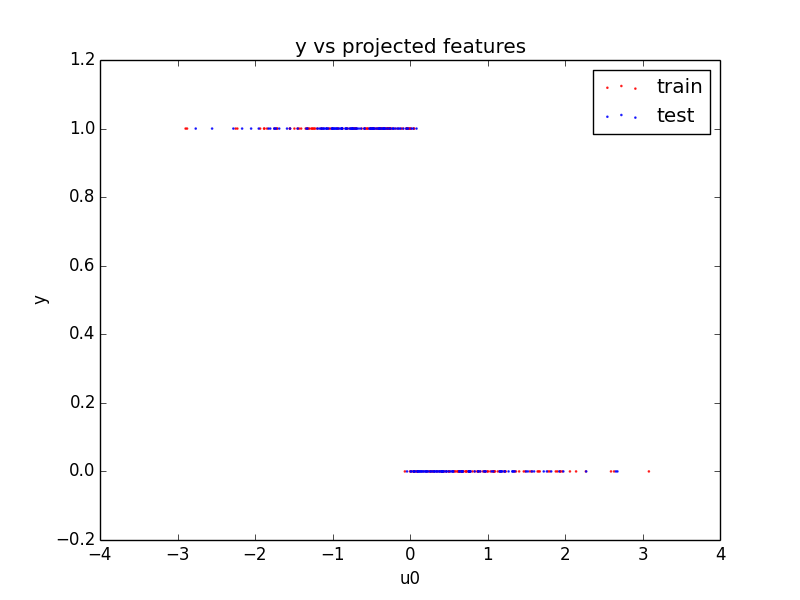

L_args len: 2
L_args len: 2
num_tight: 0
solver error: 5.29395592034e-23
num_tight: 0
solver error: 0.977031502366
L_args len: 2
num_tight: 0
solver error: 4.23516473627e-22
L_args len: 2
L_args len: 2
num_tight: 0
solver error: 0.0
num_tight: 0
solver error: 0.86539205184
L_args len: 2
num_tight: 0
solver error: 0.0
L_args len: 2
L_args len: 2
num_tight: 0
solver error: 0.0
num_tight: 0
solver error: 0.888568406808
L_args len: 2
num_tight: 0
solver error: 0.0
L_args len: 2
L_args len: 2
num_tight: 0
solver error: 0.0
num_tight: 0
solver error: 0.855314818861
L_args len: 2
num_tight: 0
solver error: 1.05879118407e-22
L_args len: 2
L_args len: 2
num_tight: 0
solver error: 0.0
num_tight: 0
solver error: 0.85489320657
L_args len: 2
num_tight: 0
solver error: 2.11758236814e-22
L_args len: 2
L_args len: 2
num_tight: 0
solver error: 2.64697796017e-23
num_tight: 0
solver error: 0.854724128116
L_args len: 2
num_tight: 0
solver error: 0.0
L_args len: 2
L_args len: 2
num_tight: 0
solver error: 2

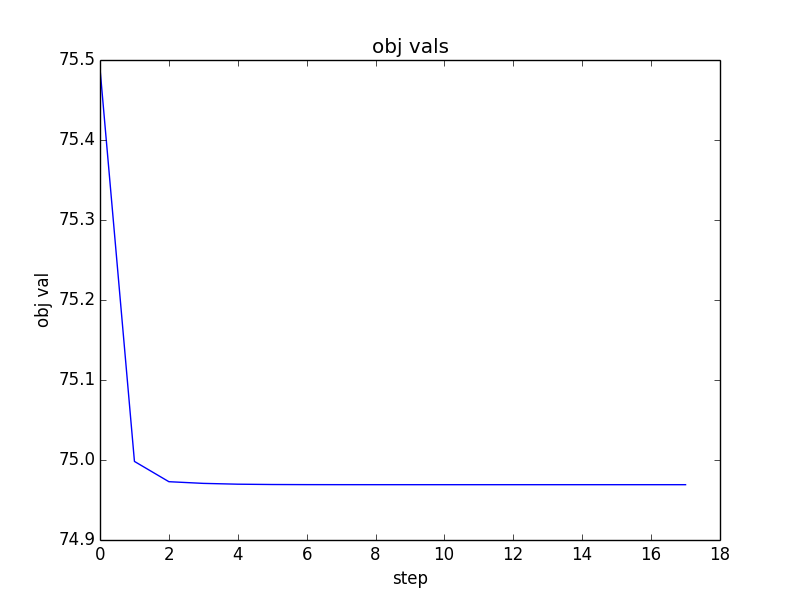

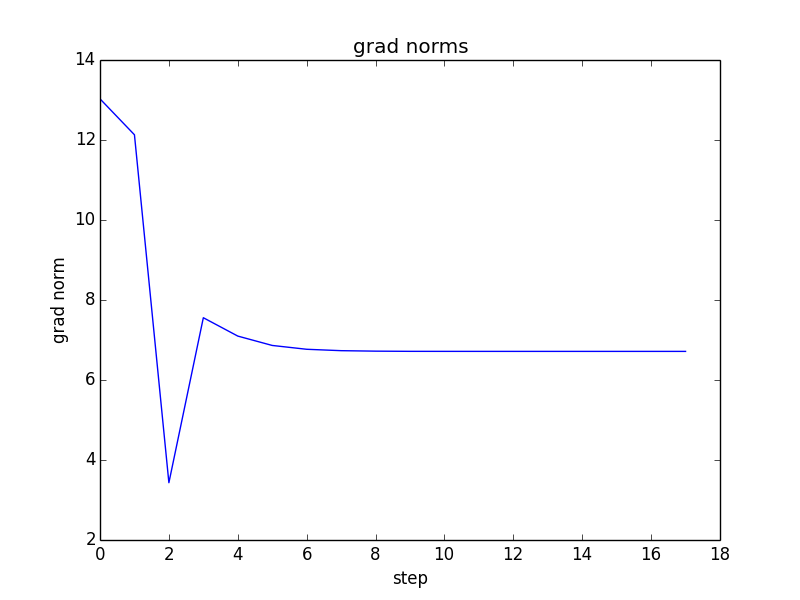

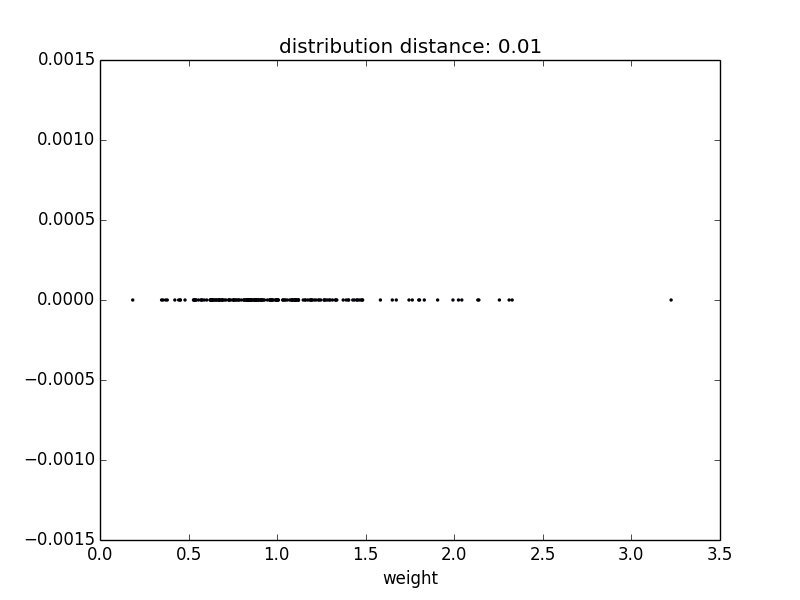

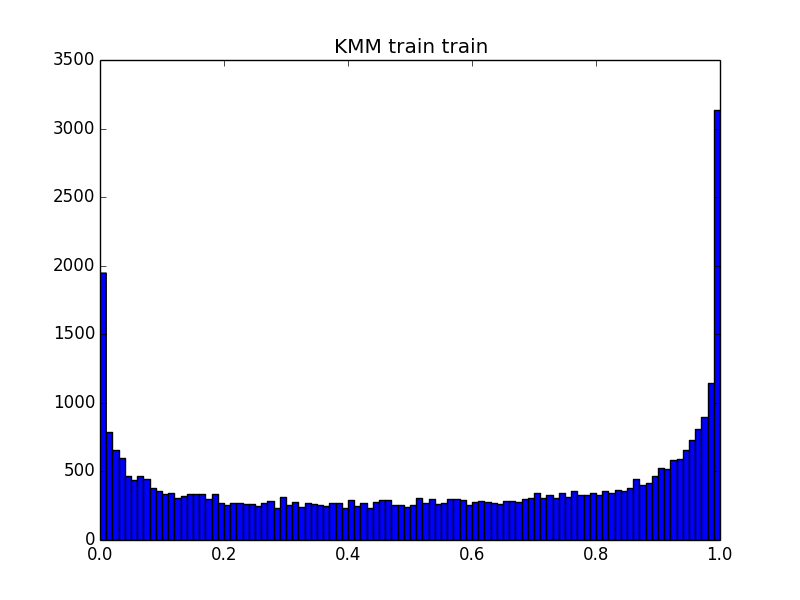

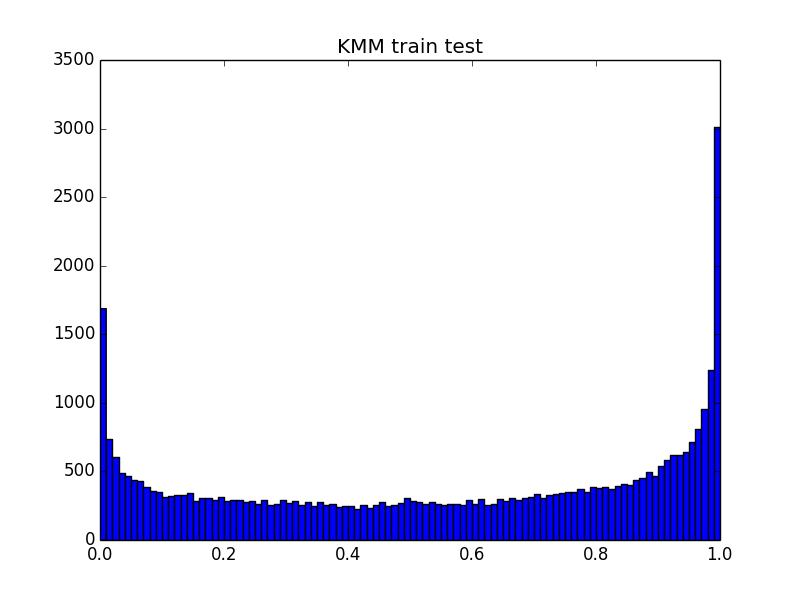

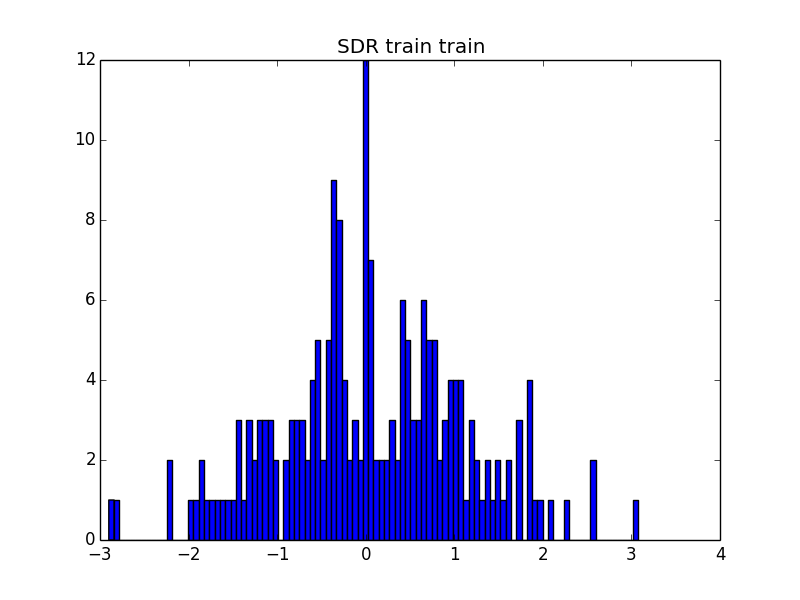

numerical gradient:
[[-0.58642666]
 [ 8.21865909]]
analytical gradient:
L_args len: 2
L_args len: 2
num_tight: 0
solver error: 0.0
num_tight: 0
solver error: 0.854632216913
L_args len: 2
num_tight: 0
solver error: 8.27180612553e-25
[[-6.74835015]
 [ 6.85233524]]


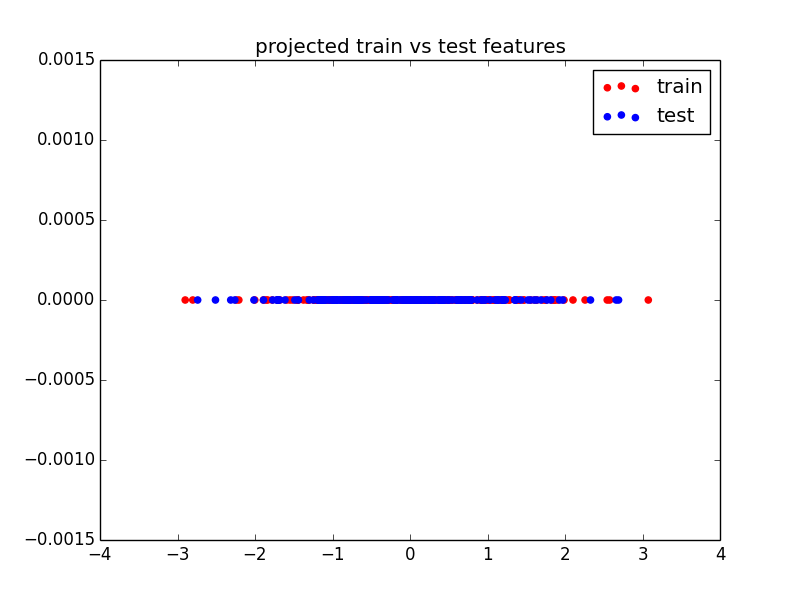

obj_val: 74.9691406172


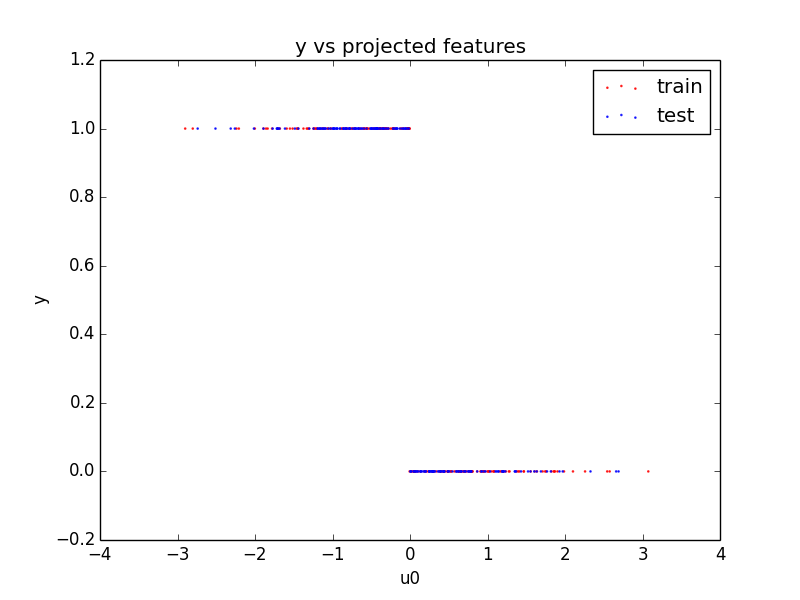

annealing step P: [[ 0.00481898]
 [-0.99998839]] 74.9691406172
plot_anneal


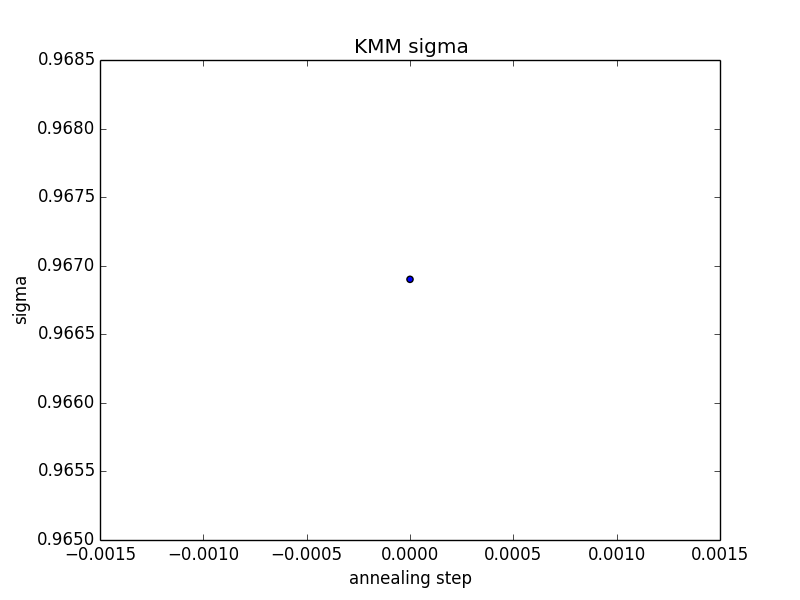

plot_anneal_step_state


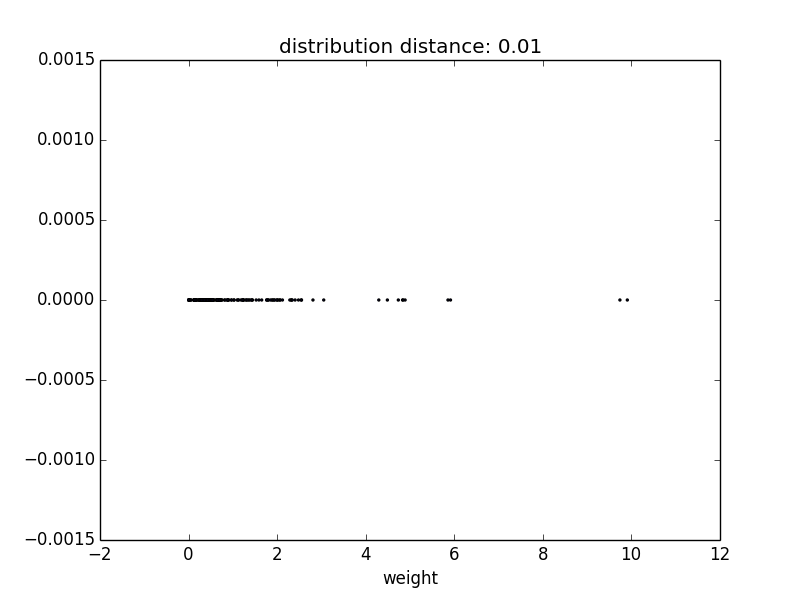

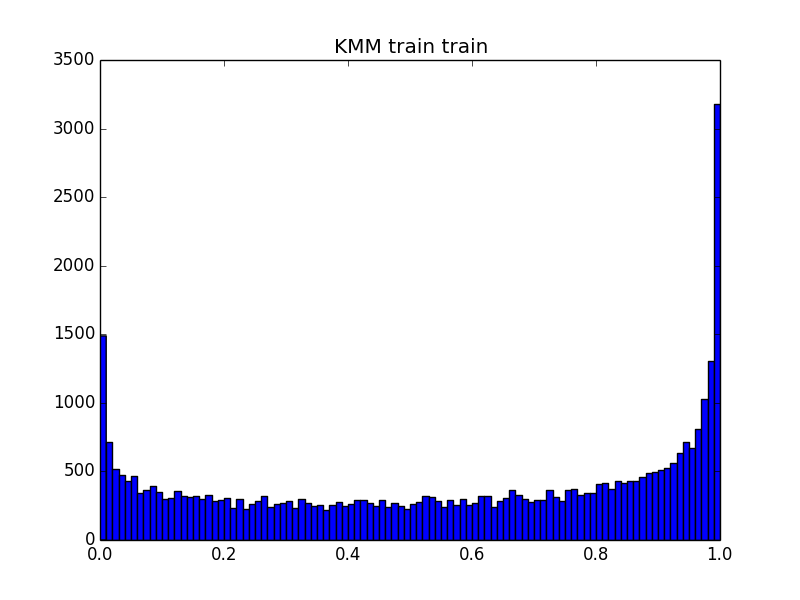

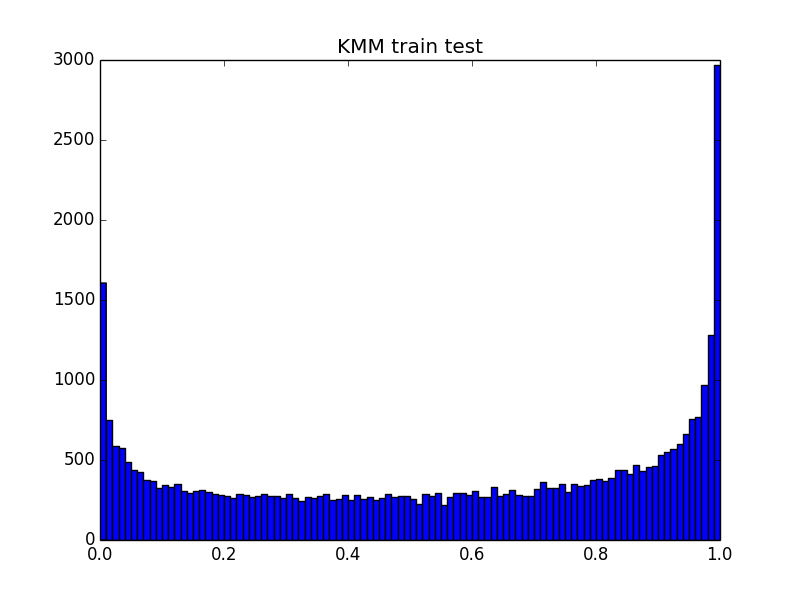

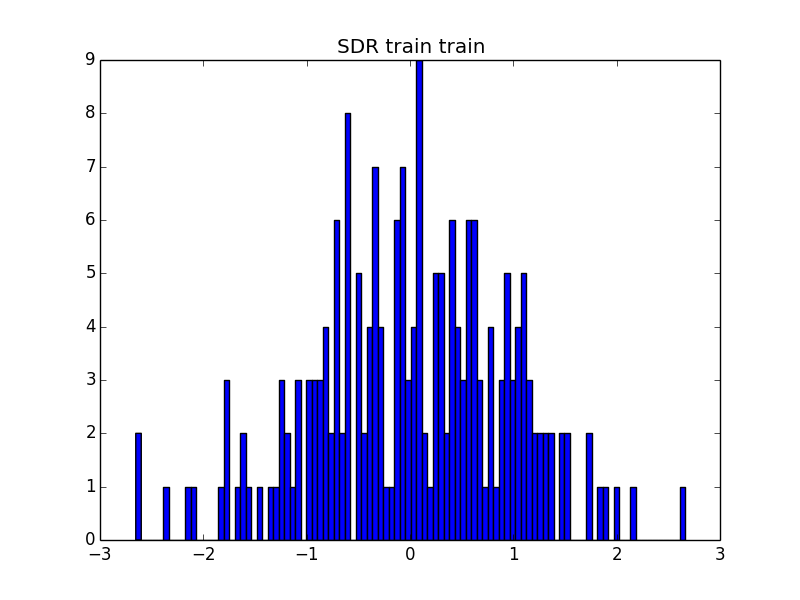

numerical gradient:
[[-140.05863465]
 [  61.70544986]]
analytical gradient:
L_args len: 2
L_args len: 2
num_tight: 0
solver error: 1.65436122511e-24
num_tight: 0
solver error: 3.60618515269
L_args len: 2
num_tight: 0
solver error: 1.65436122511e-24
[[-62.43184707]
 [ 31.84146618]]


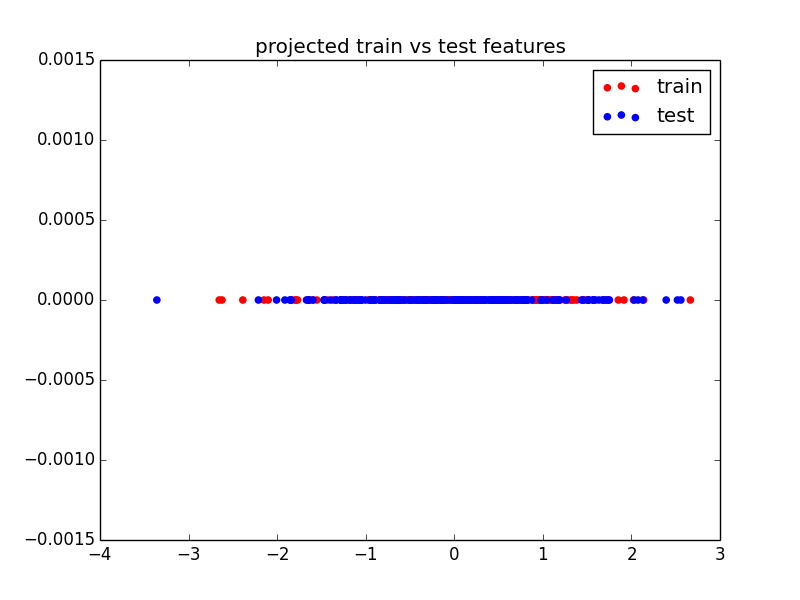

obj_val: 97.2237636966


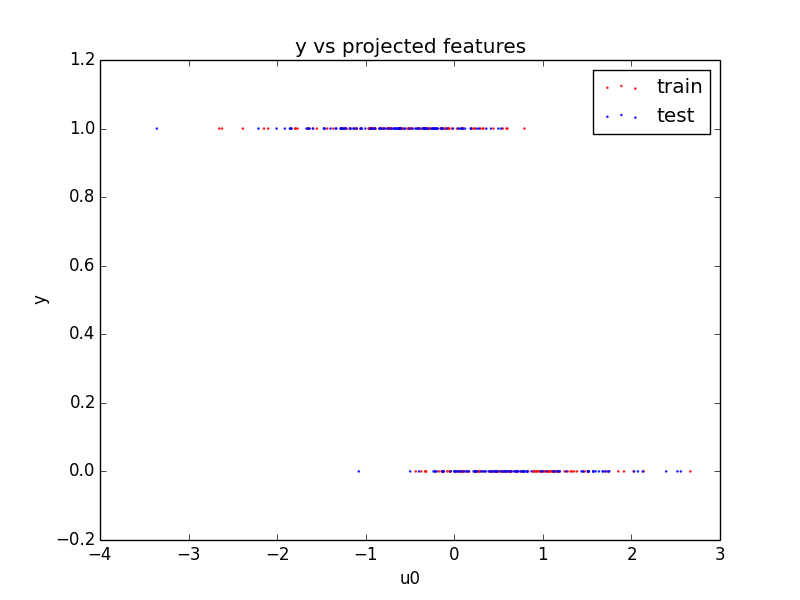

L_args len: 2
L_args len: 2
num_tight: 0
solver error: 0.0
num_tight: 0
solver error: 3.60618555568
L_args len: 2
num_tight: 0
solver error: 5.29395592034e-23
L_args len: 2
L_args len: 2
num_tight: 0
solver error: 0.0
num_tight: 0
solver error: 3.11871646308
L_args len: 2
num_tight: 0
solver error: 0.0
L_args len: 2
L_args len: 2
num_tight: 0
solver error: 0.0
num_tight: 0
solver error: 0.842556995845
L_args len: 2
num_tight: 0
solver error: 5.29395592034e-23
plot_optimize


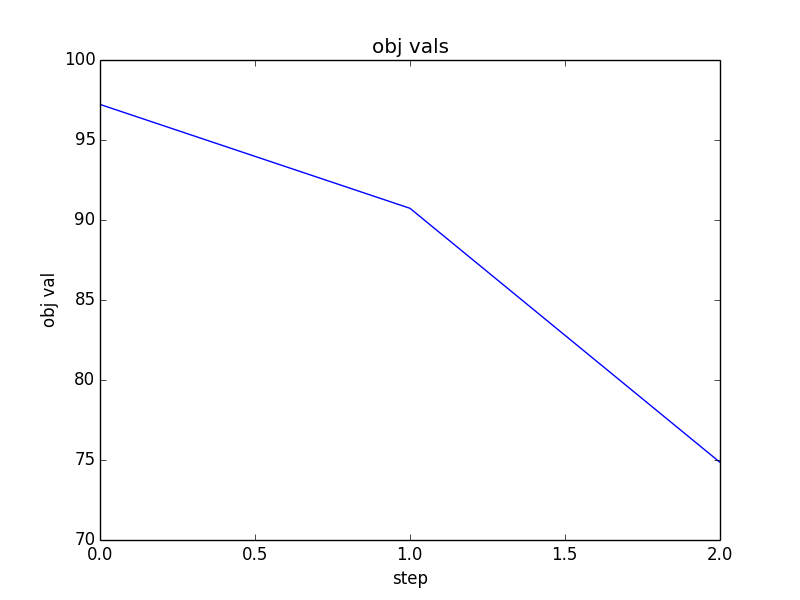

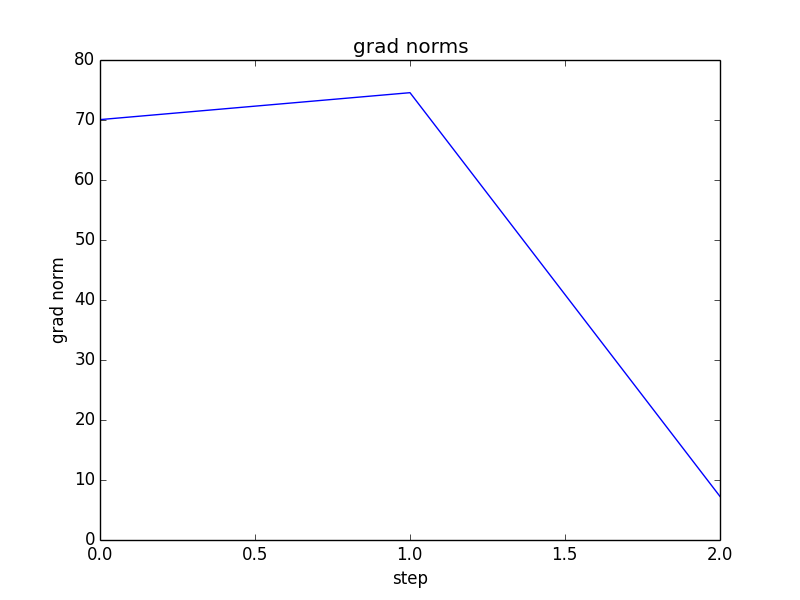

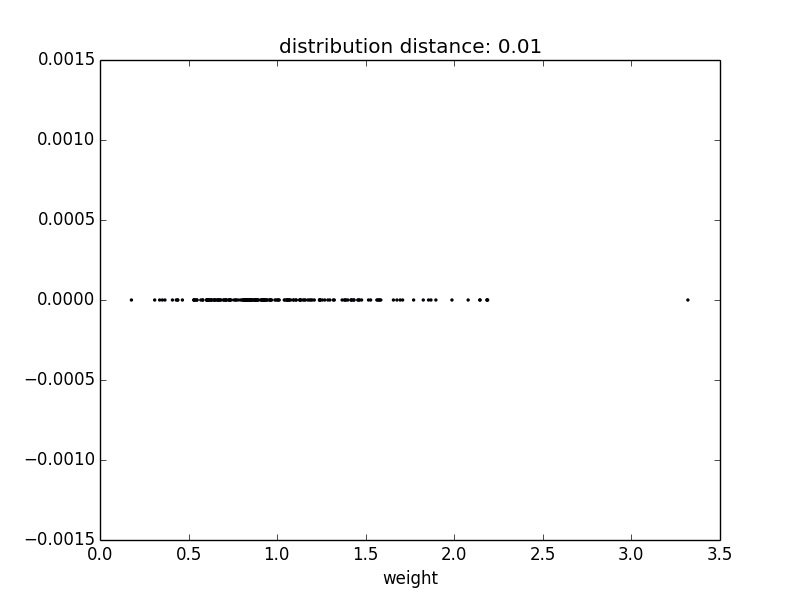

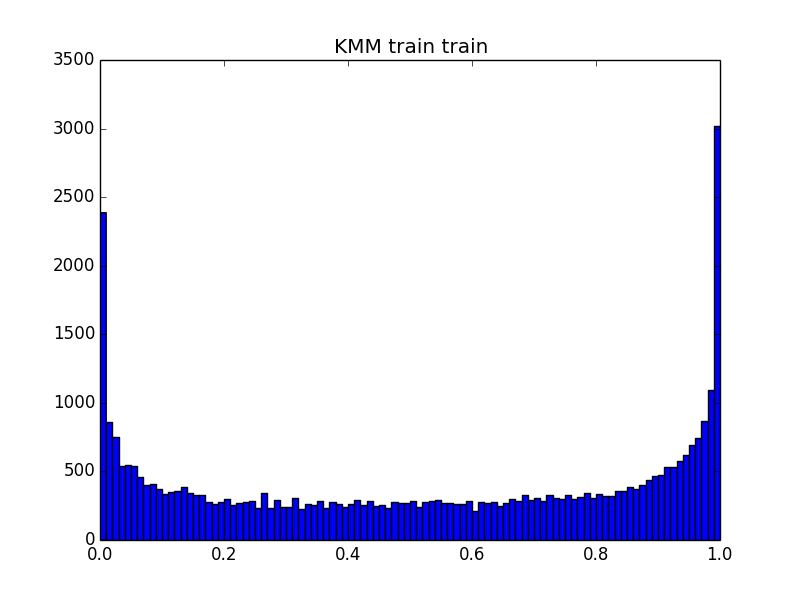

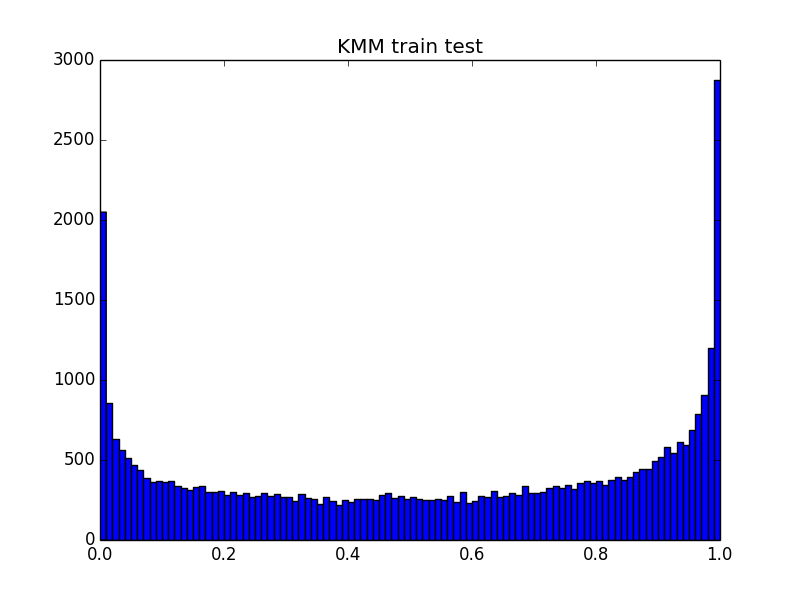

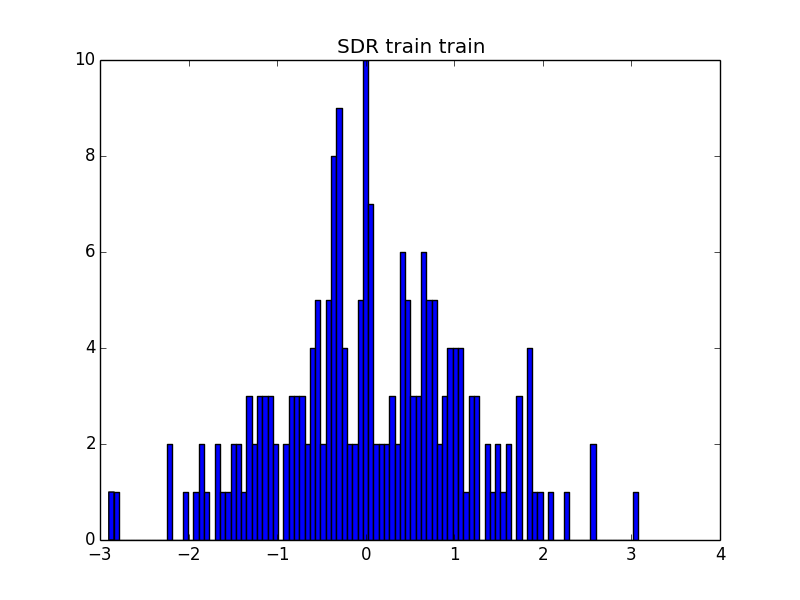

numerical gradient:
[[ 1.81061318]
 [ 6.88113661]]
analytical gradient:
L_args len: 2
L_args len: 2
num_tight: 0
solver error: 0.0
num_tight: 0
solver error: 0.84255638215
L_args len: 2
num_tight: 0
solver error: 2.48154183766e-24
[[-7.27584066]
 [ 6.79761068]]


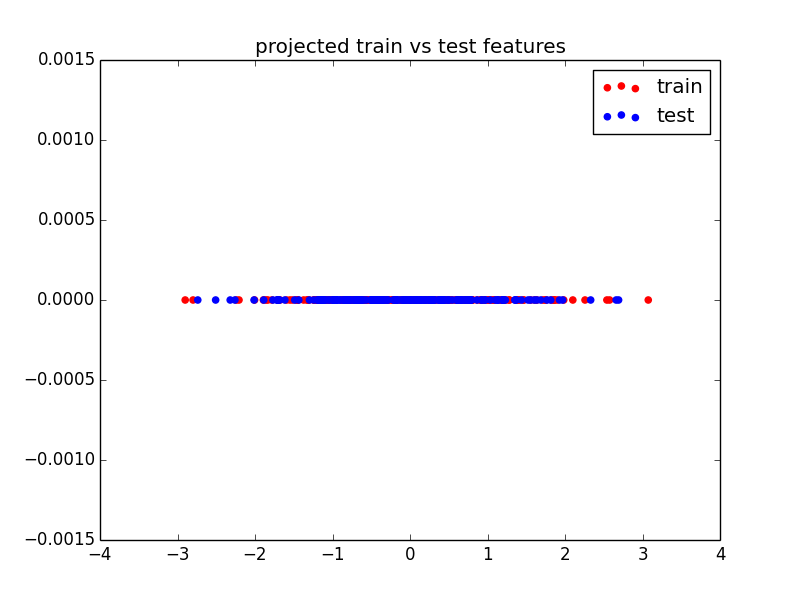

obj_val: 74.8533442496


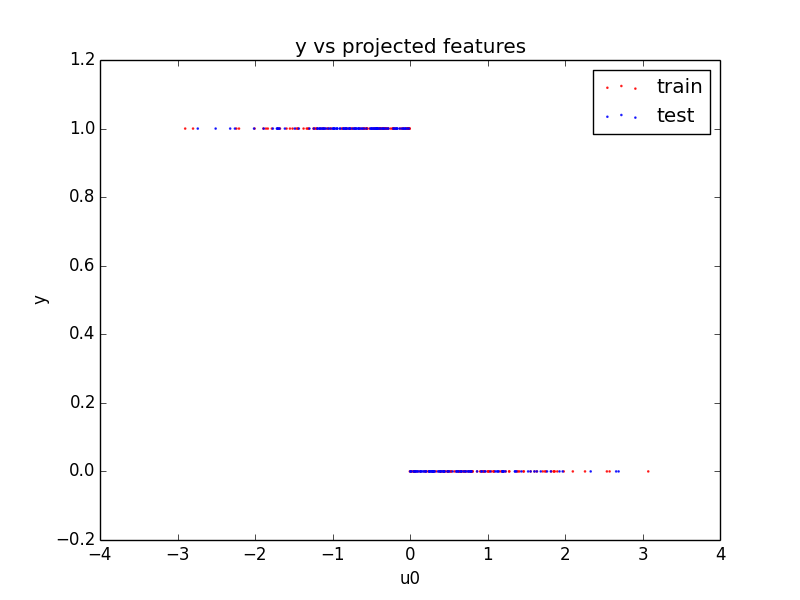

annealing step P: [[ 0.00251426]
 [-0.99999684]] 74.8533442496
plot_anneal


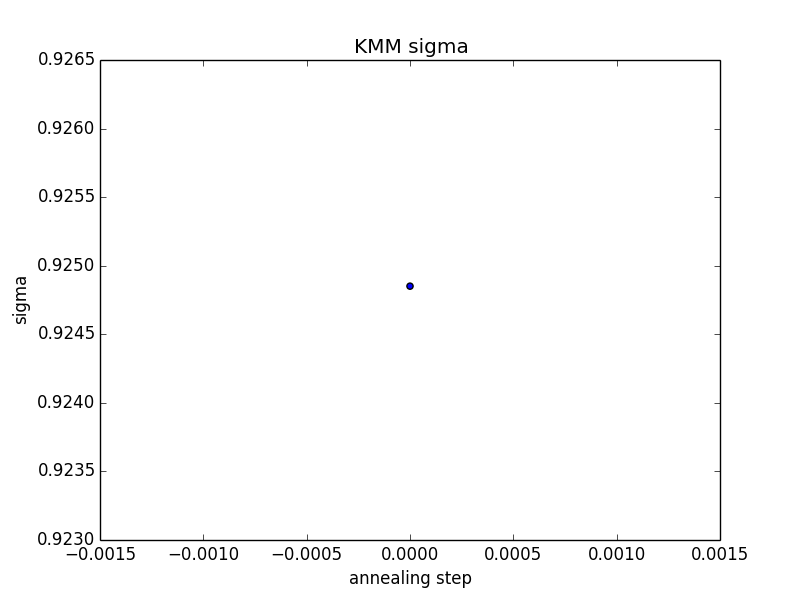

this anneal obj_val: 74.8492771067 P: [[ 0.00108873]
 [ 0.99999941]]


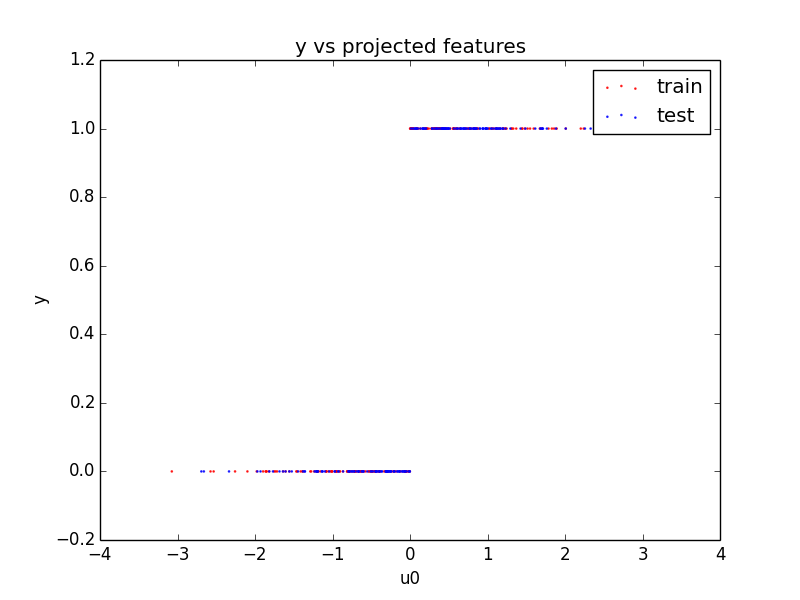

this anneal obj_val: 74.9969506875 P: [[-0.01374082]
 [ 0.99990559]]


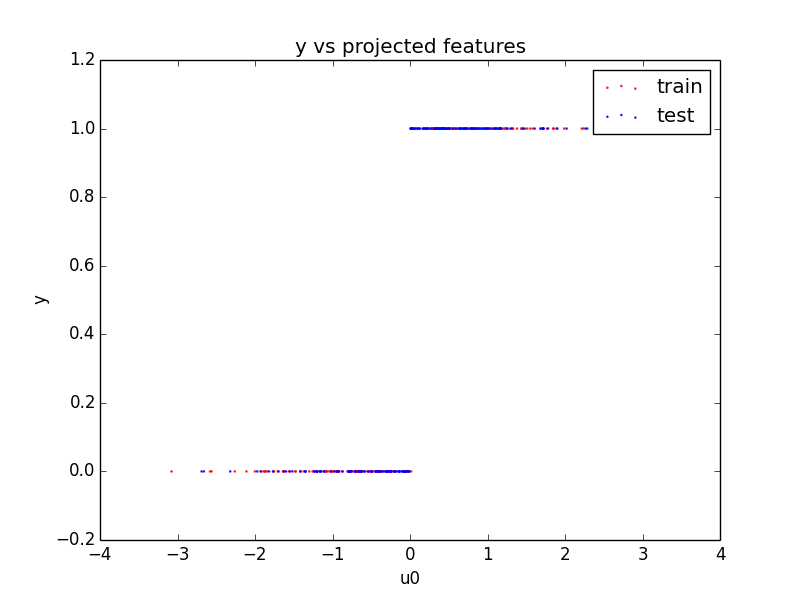

this anneal obj_val: 74.9171330282 P: [[-0.02878282]
 [ 0.99958569]]


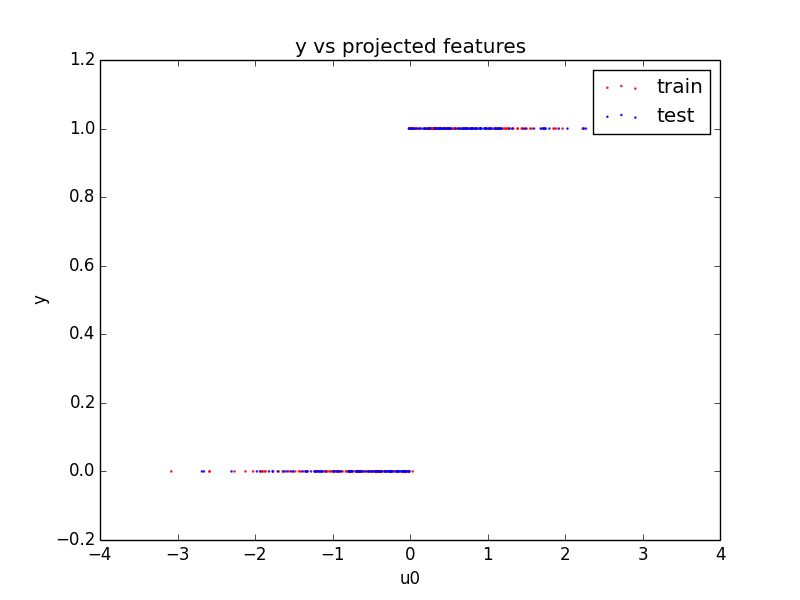

this anneal obj_val: 74.9691406172 P: [[ 0.00481898]
 [-0.99998839]]


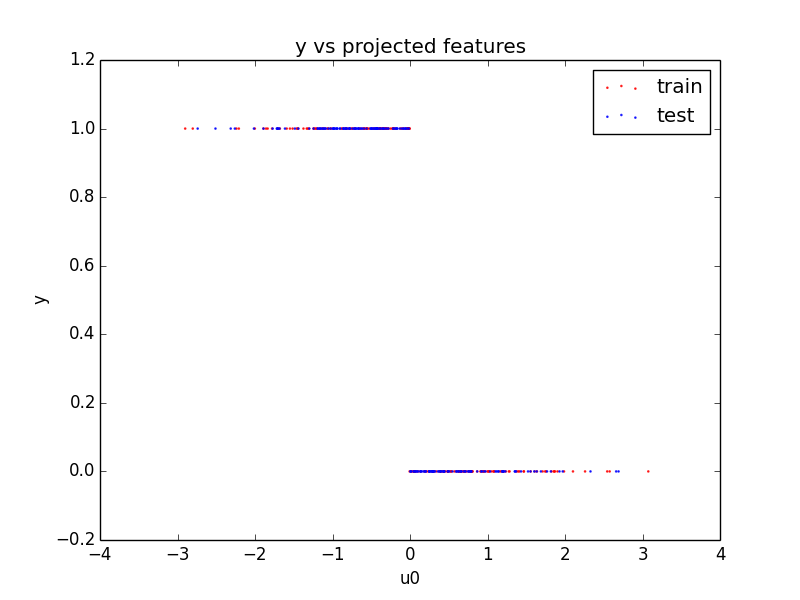

this anneal obj_val: 74.8533442496 P: [[ 0.00251426]
 [-0.99999684]]


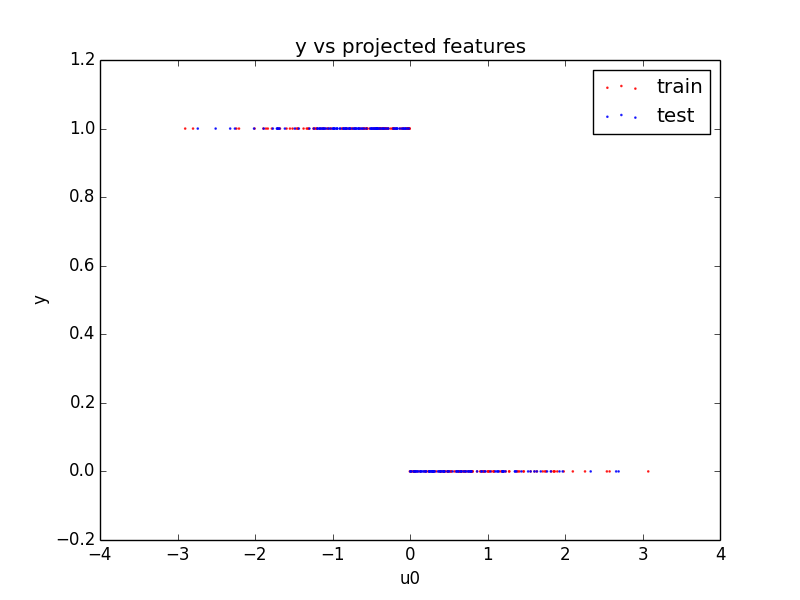

obj_vals [74.849277106725992, 74.996950687476371, 74.91713302820996, 74.96914061720841, 74.853344249558049]


In [45]:
#
multiples(plot_multiples, 5, annealer, (x_dim,desired_dim))

In [46]:
assert False

AssertionError: 

In [ ]:
# define P_init
#P_init = kernels.ortho(np.random.normal(size=(x_dim,v_dim)))
#P_init = kernels.ortho(np.array([[1.,0.]]).T)
#P_init = kernels.ortho(np.array([[1,-2.3]]).T)
#P_init = kernels.ortho(np.array([[0.,1.]]).T)
P_init = kernels.ortho(np.array([[0.19839015,0.98012313]]).T)

In [ ]:
# run
annealer(P_init)

In [ ]:
assert False